## Experimento huecos: qué algoritmo utilizamos para entrenar



A continuación vamos a coger los datos de la variable 'site_weather.csv', que están completos, y vamos a introducir 2, 5, y 10 huecos de una longitud aleatoria suponiendo una distribución normal entre 4 (1h) y 500 tomas y la distancia será siempre menor que la suma de los huecos anteriores (es la condición de fusión). Para garantizar que no están uniformemente distribuidos, iremos almacenando la longitud de hueco, y le restaremos un número aleatorio entre 1 y la longitud.




In [1]:
# Basic imports
import csv
import numpy as np
import pandas as pd
from pandas import Series
import datetime
import time
import os
import math
import seaborn as sns

path = "../../../data" #Path with raw csv files
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot
from sklearn.impute import KNNImputer

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
files = os.listdir(path)
path_postprocess = path + "_postprocess"
#in the cleaning code we insert the rows that are apparently missing

freqs = {'zone_co2.csv':'1min', 'ele.csv': '15min', 'zone_temp_sp_c.csv':'5min', 'occ.csv':'1min', 'zone_temp_exterior.csv':'1min', 'zone_temp_sp_h.csv':'5min', 'site_weather.csv':'15min', 'wifi.csv': '10min', 'zone_temp_interior.csv':'10min'}
starts = {'ele.csv': '2018/1/1 1:00', 'zone_temp_sp_c.csv':'2018/9/15 10:00', 'occ.csv':'2018-05-22 07:00:00', 'zone_temp_exterior.csv':'2018-01-01 00:00:00', 'zone_temp_sp_h.csv':'2018/9/15 10:00', 'site_weather.csv':'2018-01-01 00:00:00', 'wifi.csv': '2018/5/22 00:00', 'zone_temp_interior.csv':'2018-02-22 00:30:00'}
ends = {'ele.csv': '2021/1/1 0:00', 'zone_temp_sp_c.csv':'2021/1/1 0:00', 'occ.csv':'2019-02-21 10:12:00', 'zone_temp_exterior.csv':'2021-01-01 00:00:00', 'zone_temp_sp_h.csv':'2021/1/1 0:00', 'site_weather.csv':'2021-01-01 00:00:00', 'wifi.csv': '2018/7/11 23:50', 'zone_temp_interior.csv':'2021-01-01 00:00:00'}

## Funciones diseñadas:

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from prophet import Prophet
import random
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


In [3]:
def interpolate_Prophet(df,i, start_index, end_index):
    m = Prophet()
    s=start_index+1
    e = end_index
    
    df_medio= df.iloc[s:e, i]


    df_prophet = df[df[df.columns[i]].notna()][['date', df.columns[i]]]
    df_medio = df.iloc[s:e, [0, i]]
    df_prophet.columns = ['ds', 'y']
    m.fit(df_prophet)


    future = df_medio[['date']]
    future.columns=['ds']
    forecast_antes = m.predict(future)[['ds', 'yhat']]
    gap = forecast_antes['yhat']
    return gap

In [4]:
def interpolate_ML(df,i, start_df, end_df, start_index, end_index):
    #PASO 1: OBTENER DATOS ANTES Y DESPUÉS



    #print("Gap: \ndf before[", start_df, ':', 'start_index', start_index, ']\ndf after[', end_index, ':', end_df, ']')
    s=start_index+1
    e = end_index


    df_antes = df.iloc[start_df:s, i]
    df_despues= df.iloc[e:end_df, i].loc[::-1]
    df_medio= df.iloc[s:e, i]
    #print("Df_antes: ", df_antes.shape[0], "Df_medio: ", df_medio.shape[0], "Df_despues: ", df_despues.shape[0])

    assert df_medio.shape[0]+df_despues.shape[0]+df_antes.shape[0]==end_df-start_df
    # PASO 2: CREAR DATAFRAMES !!! SI el de después  es menor que el medio (antes siempre tenemos el resto del df), solamente ejecutamos con el de después
    if (df_despues.shape[0]<df_medio.shape[0]):
        print("Solo usamos datos anteriores")
        
        T = df_medio.shape[0]
        a = np.array(df_antes)
        train_antes =np.lib.stride_tricks.sliding_window_view(a, T+1)[:-1]
        test_antes = a[T+1:]

        svr_antes = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))
        svr_antes.fit(train_antes, test_antes)

        start = start_index-start_df
        for i in range(T):
            at = a[start-T-1+i:start+i]
            a=np.append(a,svr_antes.predict(at.reshape(1,-1)))
        gap=a[start:start+T]
        
        

    else:
        # Creamos los dataframes
        a = np.array(df_antes)
        b=np.array(df_despues)
        T = df_medio.shape[0]

        train_antes =np.lib.stride_tricks.sliding_window_view(a, T+1)[:-1]
        test_antes = a[T+1:]
        #print("train_antes, ", len(train_antes), "test_antes, ", len(test_antes))
        train_despues = np.lib.stride_tricks.sliding_window_view(b, T+1)[:-1]
        test_despues = b[T+1:]

        # PASO 3: ENTRENAR MODELOS


        svr_antes = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

        svr_antes.fit(train_antes, test_antes)
        svr_despues = make_pipeline(StandardScaler(), SVR(C=1.0, epsilon=0.2))

        svr_despues.fit(train_despues, test_despues)

        # PASO 4: OBTENER PREDICCIONES

        
        start = start_index-start_df
        for i in range(T):
            at = a[start-T-1+i:start+i]
            a=np.append(a,svr_antes.predict(at.reshape(1,-1)))

            dp = b[df_despues.shape[0]-T-1+i:df_despues.shape[0]+i]
            b=np.append(b,svr_despues.predict(dp.reshape(1,-1)))
        
        # PASO 5: COMBINAR
        predictions_antes = a[start:start+T]
        predictions_despues = b[df_despues.shape[0]:df_despues.shape[0]+T]
        gap=(predictions_antes+predictions_despues[::-1])/2
    return gap

In [5]:
def obtain_data(df, i):



    #print("Estamos en: ", i)
    k = 0

    start_index = {}
    starttime = {}
    end_index = {}
    endtime = {}
    tipo = {}

    k2 =0
    start_index_peque = {}
    starttime_peque = {}
    end_index_peque = {}
    endtime_peque = {}


    gap = {}
    start_gap_index =0
    end_gap_index =0
    start_gap_dt=datetime.datetime.strptime(str(df.iloc[0,0]), '%Y-%m-%d %H:%M:%S')
    end_gap_dt = datetime.datetime.strptime(str(df.iloc[0,0]), '%Y-%m-%d %H:%M:%S')
    for j in range(0, len(df.index)):
        

        if (pd.isnull(df.iloc[j,i]) or math.isnan(df.iloc[j,i]))and pd.isnull(df.iloc[j-1,i]) == False:
            start_gap_index = j-1
            start_gap_dt = datetime.datetime.strptime(str(df.iloc[j-1,0]), '%Y-%m-%d %H:%M:%S')
            starttime[k]=df.iloc[j-1,0] #start time of the gap
            start_index[k]=j-1
        elif (pd.isnull(df.iloc[j-1,i]) or math.isnan(df.iloc[j-1,i])) and pd.isnull(df.iloc[j,i]) == False:
            end_gap_index = j
            end_gap_dt=datetime.datetime.strptime(str(df.iloc[end_gap_index,0]), '%Y-%m-%d %H:%M:%S')
            if (abs(end_gap_dt-start_gap_dt).total_seconds()<3600):
                start_index_peque[k2] = start_gap_index
                end_index_peque[k2]=end_gap_index
                starttime_peque[k2]= df.iloc[start_gap_index,0]
                endtime_peque[k2]= df.iloc[end_gap_index,0]
                k2=k2+1
            else:
                start_index[k] = start_gap_index
                end_index[k]=end_gap_index
                starttime[k]= df.iloc[start_gap_index,0]
                endtime[k]= df.iloc[end_gap_index,0]
                tipo[k] = abs((end_gap_dt-start_gap_dt).days)+1
                
                k=k+1
    return [(start_index, end_index,tipo ), (start_index_peque, end_index_peque)]
    



In [6]:
def fill_small_gaps(df, start_index_peque, end_index_peque, i):
    k2 = len(start_index_peque)
    if k2!=0:
        for m in range(k2): 
            df.iloc[start_index_peque[m]:end_index_peque[m]+1,i]=df.iloc[start_index_peque[m]:end_index_peque[m]+1,i].interpolate(method='linear')

In [7]:
def mix_big_gaps(start_index, end_index, tipo, freq=4):
    k = len(start_index)
    gaps = {}
    days_interpolation ={}
    t =0
    m =0
    if k!=0:
        while (m<k):
            #print("Estoy en: ", m)
            gap = m
            next_gap = m+1 
            start = start_index[m]
            end_index_t = end_index[m]
            current_gap = [[start_index[m], end_index[m], 0, end_index[m]-start_index[m]]]
            type = tipo[m]
            T = abs(end_index[m]-start_index[m])
            
            while (next_gap<k and abs(end_index_t-start_index[next_gap])<T ):
                #print("Fusión en: ", gap, "con ", next_gap)
                #print("T: ", abs(end_index_t-start))
                m= m+1
                local_index = current_gap[-1][3]+(start_index[next_gap]-end_index_t)
                #Si está muy cerca se lo metemos al current_gap
                current_gap.append([start_index[next_gap], end_index[next_gap], local_index,local_index+(end_index[next_gap]-start_index[next_gap])])
                
                type = type + tipo[m]
                end_index_t = end_index[next_gap]
                next_gap= next_gap +1
                T = abs(end_index_t-start)
                
            m = m+1
            gaps[t]=current_gap
            days_interpolation[t]=type
            t=t+1   
        return (gaps, days_interpolation)


In [8]:
def fill_big_gaps(df, gaps, days_interpolation, i, freq=4):
    k = len(gaps)
    if k!=0:
        for m in range(k):
            
            days = days_interpolation[m]
            start_i = gaps[m][0][0]
            end_i = gaps[m][-1][1]
            #print("We are in gap: ", m, "\nMixed gaps: ", gaps[m])
            #print("Gap of " , days, 'days')

            end_gap_anterior = (gaps[m-1][-1][1])if m>0 else 0
            start_gap_siguiente = (gaps[m+1][0][0])if m+1!=k else len(df.index)
            # Si el anterior ha acabado hace más de una semana, nos quedamos con el que se hace una semana justa

            start_df = start_i-(days*7*freq*24) if (start_i-days*7*freq*24>=0 ) else 0
            
            
            # Si el sigueinte empieza más tarde de una semana, nos quedamos con la semana siguiente solamente
            end_df = end_i+(days*7*freq*24) if (start_gap_siguiente-end_i > days*7*freq*24 ) else start_gap_siguiente
            results = interpolate_ML(df,i, start_df, end_df, start_i, end_i)
            pos =0
            for independent_gap in gaps[m]:
                
                df.iloc[independent_gap[0]+1:independent_gap[1],i]=results[independent_gap[2]:independent_gap[3]-1]
            
                
        
        

In [9]:
def clean_df_var(df, i, show=False):
    copia = df[['date', df.columns[i]]].copy()
    data = obtain_data(df, i)
    start_index, end_index,tipo = data[0]
    start_index_peque, end_index_peque=data[1]
    fill_small_gaps(df, start_index_peque, end_index_peque, i)
    gaps, days_interpolation = mix_big_gaps(start_index, end_index, tipo)
    fill_big_gaps(df, gaps, days_interpolation, i)
    print("Finished: ", df.columns[i])
    if(show):
        fig = make_subplots(rows=2, cols=1,  shared_xaxes=True, subplot_titles=("Bruto",  "Final") )


        fig.add_trace(
            go.Scatter(x=copia.date , y=copia[df.columns[i]]),
            row=1, col=1
        )

        fig.add_trace(
            go.Scatter(x=df.date , y=df[df.columns[i]]),
            row=2, col=1
        )



        fig.update_layout(legend_orientation="h", 
                    xaxis2_rangeslider_visible=True, xaxis2_rangeslider_thickness=0.1, height=600, width=800, title_text="Mels_S" )
        fig.show()


## Ejecución del experimento

In [10]:
file = 'site_weather.csv'
df = pd.read_csv(path+'/'+file)
path_2 = '../data_postprocess/data_done'
print(path+'/'+file)
start = starts[file]
end = ends[file]
freq = freqs[file]
df['date'] = pd.to_datetime(df['date']) 
df =df[(df.date>=start)&(df.date<=end)]
helper=pd.DataFrame({'date': pd.date_range(start, end, freq=freq)})
df = pd.merge(df, helper, on='date', how='outer').sort_values('date')

df.sort_values(by='date', inplace=True)
df = df[df.date <= '2020-03-01']

df.head()
var='air_temp_set_1'

fig = go.Figure()
fig.add_trace(
    go.Scatter(x=df.date , y=df[var])
)
fig.update_layout(legend_orientation="v", 
             xaxis_rangeslider_visible=True, xaxis_rangeslider_thickness=0.1, height=600, width=1000 )
fig.show()
#  Vamos a probar haciendo downsampling a 15 minutos


../../../data/site_weather.csv


In [11]:
df = df[['date', var]]
copia = df.copy()
copia.set_index('date', inplace=True)

In [12]:
def experimento_huecos(iteraciones, num_huecos, copia, freq=4):
    tiempos =[[],[],[]]
    mse=[[],[],[]]
    mae=[[],[],[]]
    mape=[[],[],[]]

    for j in range(iteraciones):

        print("\nINFORMACIÓN ITERACIÓN ", j)
        df = copia.copy()
        df.reset_index(inplace=True)
        
        min_index = 500*(num_huecos)+500*(num_huecos-1)
        index_inicial = random.randint(min_index, df.shape[0]-min_index)
        #Generamos las longitudes de los huecos
        longitud = []
        for i in range(num_huecos):
            longitud.append(int(random.normalvariate(250, 50)))

        #Generamos las distancias entre huecos
        distancias = []
        distancia_acumulada = longitud[0]
        for i in range(num_huecos):
            distancias.append(distancia_acumulada-int(random.randint(1, distancia_acumulada)))
        i_actual = index_inicial

        #Insertamos valores nulos
        for i in range(num_huecos):

            df.iloc[i_actual:i_actual+longitud[i], 1] = np.nan
            i_actual = i_actual+longitud[i]+distancias[i]


        df1 = df.copy()
        df2 = df.copy()
        index_final = i_actual


        data = obtain_data(df, 1)
        start_index, end_index,tipo = data[0]
        start_index_peque, end_index_peque=data[1]
        fill_small_gaps(df, start_index_peque, end_index_peque, 1)
        gaps, days_interpolation = mix_big_gaps(start_index, end_index, tipo)

        m=0
        k = len(gaps)
        freq =4

        days = days_interpolation[m]
        start_i = gaps[m][0][0]
        end_i = gaps[m][-1][1]
        

        inicio = time.time()
        results = interpolate_Prophet(df,1, start_i, end_i)
        fin=time.time()
        temp_mse =0
        temp_mae =0
        temp_mape =0
        for independent_gap in gaps[m]:
            temp_mse =temp_mse+ mean_squared_error(copia.iloc[independent_gap[0]+1:independent_gap[1],0], results[independent_gap[2]:independent_gap[3]-1])
            temp_mae =temp_mae+ mean_absolute_error(copia.iloc[independent_gap[0]+1:independent_gap[1],0], results[independent_gap[2]:independent_gap[3]-1])
            temp_mape =temp_mape+ mean_absolute_percentage_error(copia.iloc[independent_gap[0]+1:independent_gap[1],0], results[independent_gap[2]:independent_gap[3]-1])

        temp_mse = temp_mse/len(gaps[m])
        temp_mae = temp_mae/len(gaps[m])
        temp_mape = temp_mape/len(gaps[m])
        mse[0].append(temp_mse)
        mae[0].append(temp_mae)
        mape[0].append(temp_mape)
        tiempos[0].append(fin-inicio)
        print("Tiempo Prophet: ", fin-inicio)
        print("MSE Prophet: ", temp_mse)

        end_gap_anterior = (gaps[m-1][-1][1])if m>0 else 0
        start_gap_siguiente = (gaps[m+1][0][0])if m+1!=k else len(df1.index)
        for f in [2,7]:
            start_df = start_i-(days*f*freq*24) if (start_i-days*f*freq*24>=0 ) else 0
            # Si el sigueinte empieza más tarde de una semana, nos quedamos con la semana siguiente solamente
            end_df = end_i+(days*f*freq*24) if (start_gap_siguiente-end_i > days*f*freq*24 ) else start_gap_siguiente
            inicio=time.time()
            results = interpolate_ML(df1,1, start_df, end_df, start_i, end_i)
            fin=time.time()
            temp_mse =0
            temp_mae =0
            temp_mape =0
            for independent_gap in gaps[m]:
                temp_mse =temp_mse+ mean_squared_error(copia.iloc[independent_gap[0]+1:independent_gap[1],0], results[independent_gap[2]:independent_gap[3]-1])
                temp_mae =temp_mae+ mean_absolute_error(copia.iloc[independent_gap[0]+1:independent_gap[1],0], results[independent_gap[2]:independent_gap[3]-1])
                temp_mape =temp_mape+ mean_absolute_percentage_error(copia.iloc[independent_gap[0]+1:independent_gap[1],0], results[independent_gap[2]:independent_gap[3]-1])

            temp_mse = temp_mse/len(gaps[m])
            temp_mae = temp_mae/len(gaps[m])
            temp_mape = temp_mape/len(gaps[m])
            
            
            if(f==2):
                
                print("Tiempo 2: ", fin-inicio)
                print("MSE 2: ", temp_mse)
                mse[1].append(temp_mse)
                mae[1].append(temp_mae)
                mape[1].append(temp_mape)
                tiempos[1].append(fin-inicio)
            elif(f==7):
                print("Tiempo 7: ", fin-inicio)
                print("MSE 7: ", temp_mse)
                mse[2].append(temp_mse)
                mae[2].append(temp_mae)
                mape[2].append(temp_mape)
                tiempos[2].append(fin-inicio)
    
  
    return tiempos, mse, mae, mape



In [13]:
times=[]
mse_total =[]
mae_total=[]
mape_total=[]

for hueco in range(1,11):
    print('\n\nHUECOS: ', hueco)
    data = experimento_huecos(20, hueco, copia)
    times.append(data[0])
    mse_total.append(data[1])
    mae_total.append(data[2])
    mape_total.append(data[3])

    print(data)

    
    print("\n===============RESUMEN LONGITUD ", hueco, "=======================================")

    print('MSE 2',np.array(data[1][1]).mean())
    print('MSE semana',np.array(data[1][2]).mean())
    print('MSE prophet',np.array(data[1][0]).mean())
    print("\n=====================================================================================")






HUECOS:  1

INFORMACIÓN ITERACIÓN  0


15:35:18 - cmdstanpy - INFO - Chain [1] start processing
15:35:44 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  30.555694103240967
MSE Prophet:  4.776500872689655
Tiempo 2:  0.06939506530761719
MSE 2:  4.007645665748978
Tiempo 7:  0.5433471202850342
MSE 7:  2.431820555947883

INFORMACIÓN ITERACIÓN  1


15:35:53 - cmdstanpy - INFO - Chain [1] start processing
15:36:31 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  42.40664982795715
MSE Prophet:  4.379986256088144
Tiempo 2:  0.06822514533996582
MSE 2:  27.380838121010267
Tiempo 7:  0.554530143737793
MSE 7:  2.309321578346949

INFORMACIÓN ITERACIÓN  2


15:36:41 - cmdstanpy - INFO - Chain [1] start processing
15:37:15 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  38.66660404205322
MSE Prophet:  1.6651656569354656
Tiempo 2:  0.09025216102600098
MSE 2:  1.58469115873708
Tiempo 7:  1.0875451564788818
MSE 7:  1.7449885588485263

INFORMACIÓN ITERACIÓN  3


15:37:25 - cmdstanpy - INFO - Chain [1] start processing
15:38:20 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  59.476802825927734
MSE Prophet:  9.929639115006067
Tiempo 2:  0.07350277900695801
MSE 2:  4.247166396370574
Tiempo 7:  0.5928568840026855
MSE 7:  10.863879713646957

INFORMACIÓN ITERACIÓN  4


15:38:30 - cmdstanpy - INFO - Chain [1] start processing
15:39:14 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  48.605891942977905
MSE Prophet:  8.446227569324417
Tiempo 2:  0.07212519645690918
MSE 2:  13.35156995585115
Tiempo 7:  0.3529069423675537
MSE 7:  12.073304427534799

INFORMACIÓN ITERACIÓN  5


15:39:24 - cmdstanpy - INFO - Chain [1] start processing
15:39:49 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  29.9546959400177
MSE Prophet:  4.448002524498188
Tiempo 2:  0.03708910942077637
MSE 2:  5.460003398631657
Tiempo 7:  0.23325824737548828
MSE 7:  11.958685619995833

INFORMACIÓN ITERACIÓN  6


15:39:59 - cmdstanpy - INFO - Chain [1] start processing
15:40:44 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  49.980841875076294
MSE Prophet:  45.79762039166544
Tiempo 2:  0.1052999496459961
MSE 2:  8.038304270418212
Tiempo 7:  1.0914409160614014
MSE 7:  18.279205557206268

INFORMACIÓN ITERACIÓN  7


15:40:55 - cmdstanpy - INFO - Chain [1] start processing
15:41:41 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  50.49893522262573
MSE Prophet:  11.533598403295741
Tiempo 2:  0.07094502449035645
MSE 2:  14.759857345451087
Tiempo 7:  0.5601158142089844
MSE 7:  12.182953712785512

INFORMACIÓN ITERACIÓN  8


15:41:51 - cmdstanpy - INFO - Chain [1] start processing
15:42:15 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  28.933143854141235
MSE Prophet:  16.331809208154628
Tiempo 2:  0.07495808601379395
MSE 2:  15.736641871004299
Tiempo 7:  0.5170919895172119
MSE 7:  11.563314889543303

INFORMACIÓN ITERACIÓN  9


15:42:25 - cmdstanpy - INFO - Chain [1] start processing
15:43:09 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  48.89991617202759
MSE Prophet:  5.982945875985686
Tiempo 2:  0.06524419784545898
MSE 2:  2.4974024097197605
Tiempo 7:  0.4896728992462158
MSE 7:  2.732093596397637

INFORMACIÓN ITERACIÓN  10


15:43:19 - cmdstanpy - INFO - Chain [1] start processing
15:43:52 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  38.17248892784119
MSE Prophet:  3.496415349846771
Tiempo 2:  0.06433582305908203
MSE 2:  6.178702013157225
Tiempo 7:  0.5976629257202148
MSE 7:  19.0034761871025

INFORMACIÓN ITERACIÓN  11


15:44:02 - cmdstanpy - INFO - Chain [1] start processing
15:44:43 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  45.131011724472046
MSE Prophet:  4.091994659476001
Tiempo 2:  0.040075063705444336
MSE 2:  2.7004492466631387
Tiempo 7:  0.2122187614440918
MSE 7:  2.5010174464526007

INFORMACIÓN ITERACIÓN  12


15:44:53 - cmdstanpy - INFO - Chain [1] start processing
15:45:19 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  30.842411041259766
MSE Prophet:  20.123009267246402
Tiempo 2:  0.09682369232177734
MSE 2:  24.661290099996148
Tiempo 7:  0.6565098762512207
MSE 7:  33.123651967432366

INFORMACIÓN ITERACIÓN  13


15:45:29 - cmdstanpy - INFO - Chain [1] start processing
15:46:18 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  53.44109582901001
MSE Prophet:  1.309469021656237
Tiempo 2:  0.1003420352935791
MSE 2:  2.415625018987803
Tiempo 7:  1.0880341529846191
MSE 7:  4.729568467294765

INFORMACIÓN ITERACIÓN  14


15:46:28 - cmdstanpy - INFO - Chain [1] start processing
15:47:09 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  45.72970485687256
MSE Prophet:  7.01913991178482
Tiempo 2:  0.09560990333557129
MSE 2:  1.1512449627023613
Tiempo 7:  0.995474100112915
MSE 7:  1.3968675005367428

INFORMACIÓN ITERACIÓN  15


15:47:20 - cmdstanpy - INFO - Chain [1] start processing
15:47:48 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  33.332109212875366
MSE Prophet:  26.35038431285308
Tiempo 2:  0.041069984436035156
MSE 2:  6.599393832210693
Tiempo 7:  0.20694303512573242
MSE 7:  27.79113765538087

INFORMACIÓN ITERACIÓN  16


15:48:00 - cmdstanpy - INFO - Chain [1] start processing
15:48:20 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  26.17671799659729
MSE Prophet:  5.805773943220575
Tiempo 2:  0.07350015640258789
MSE 2:  15.277568612379204
Tiempo 7:  0.5404741764068604
MSE 7:  1.3740096676005675

INFORMACIÓN ITERACIÓN  17


15:48:31 - cmdstanpy - INFO - Chain [1] start processing
15:49:09 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  43.020240783691406
MSE Prophet:  28.067422378565855
Tiempo 2:  0.0656290054321289
MSE 2:  25.201831088942644
Tiempo 7:  0.5605049133300781
MSE 7:  28.96063322359541

INFORMACIÓN ITERACIÓN  18


15:49:19 - cmdstanpy - INFO - Chain [1] start processing
15:49:45 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  30.882730960845947
MSE Prophet:  4.231569152168306
Tiempo 2:  0.0684821605682373
MSE 2:  9.340675483818332
Tiempo 7:  0.6183929443359375
MSE 7:  3.2787641625417674

INFORMACIÓN ITERACIÓN  19


15:49:55 - cmdstanpy - INFO - Chain [1] start processing
15:50:43 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  52.29372978210449
MSE Prophet:  7.713815094087361
Tiempo 2:  0.06600499153137207
MSE 2:  8.765100150533673
Tiempo 7:  0.48617100715637207
MSE 7:  11.579979918087997
([[30.555694103240967, 42.40664982795715, 38.66660404205322, 59.476802825927734, 48.605891942977905, 29.9546959400177, 49.980841875076294, 50.49893522262573, 28.933143854141235, 48.89991617202759, 38.17248892784119, 45.131011724472046, 30.842411041259766, 53.44109582901001, 45.72970485687256, 33.332109212875366, 26.17671799659729, 43.020240783691406, 30.882730960845947, 52.29372978210449], [0.06939506530761719, 0.06822514533996582, 0.09025216102600098, 0.07350277900695801, 0.07212519645690918, 0.03708910942077637, 0.1052999496459961, 0.07094502449035645, 0.07495808601379395, 0.06524419784545898, 0.06433582305908203, 0.040075063705444336, 0.09682369232177734, 0.1003420352935791, 0.09560990333557129, 0.041069984436035156, 0.07350015640258789, 0.0656290054321289, 0.0684821605682373, 0.06600499153137207], [0.54

15:50:53 - cmdstanpy - INFO - Chain [1] start processing
15:51:43 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  55.19276809692383
MSE Prophet:  6.97615707953986
Tiempo 2:  0.26073288917541504
MSE 2:  5.628847104351686
Tiempo 7:  3.6135950088500977
MSE 7:  7.166806796662798

INFORMACIÓN ITERACIÓN  1


15:51:57 - cmdstanpy - INFO - Chain [1] start processing
15:52:53 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  61.45467972755432
MSE Prophet:  12.657024486200696
Tiempo 2:  0.274677038192749
MSE 2:  15.451654278655166
Tiempo 7:  3.351285934448242
MSE 7:  11.354430280806437

INFORMACIÓN ITERACIÓN  2


15:53:06 - cmdstanpy - INFO - Chain [1] start processing
15:53:46 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  44.455228090286255
MSE Prophet:  2.345852553224751
Tiempo 2:  0.394061803817749
MSE 2:  4.268963699849863
Tiempo 7:  5.714333772659302
MSE 7:  1.3734933200146129

INFORMACIÓN ITERACIÓN  3


15:54:02 - cmdstanpy - INFO - Chain [1] start processing
15:54:56 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  58.4967999458313
MSE Prophet:  10.204502137360748
Tiempo 2:  0.3874499797821045
MSE 2:  9.620412696205374
Tiempo 7:  6.324129104614258
MSE 7:  48.05358285837444

INFORMACIÓN ITERACIÓN  4


15:55:13 - cmdstanpy - INFO - Chain [1] start processing
15:56:28 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  79.34573602676392
MSE Prophet:  24.904150290357133
Tiempo 2:  0.4766409397125244
MSE 2:  15.624378116403754
Tiempo 7:  3.61080002784729
MSE 7:  16.747903731476452

INFORMACIÓN ITERACIÓN  5


15:56:41 - cmdstanpy - INFO - Chain [1] start processing
15:57:31 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  55.30695176124573
MSE Prophet:  5.464871983639857
Tiempo 2:  0.3048090934753418
MSE 2:  4.910143424018266
Tiempo 7:  4.9262330532073975
MSE 7:  11.459705484262594

INFORMACIÓN ITERACIÓN  6


15:57:46 - cmdstanpy - INFO - Chain [1] start processing
15:58:42 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  60.33124399185181
MSE Prophet:  73.99978733728719
Tiempo 2:  0.23562908172607422
MSE 2:  99.96313665558998
Tiempo 7:  3.022922992706299
MSE 7:  98.56416688084913

INFORMACIÓN ITERACIÓN  7


15:58:54 - cmdstanpy - INFO - Chain [1] start processing
15:59:39 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  49.47634315490723
MSE Prophet:  23.41804561362283
Tiempo 2:  0.4290900230407715
MSE 2:  19.445602430203813
Tiempo 7:  5.517333984375
MSE 7:  21.656298835475862

INFORMACIÓN ITERACIÓN  8


15:59:54 - cmdstanpy - INFO - Chain [1] start processing
16:00:35 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  45.12969493865967
MSE Prophet:  8.80415310741283
Tiempo 2:  0.345134973526001
MSE 2:  10.53536196488059
Tiempo 7:  6.02114200592041
MSE 7:  26.098938899612747

INFORMACIÓN ITERACIÓN  9


16:00:51 - cmdstanpy - INFO - Chain [1] start processing
16:01:32 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  45.41516590118408
MSE Prophet:  7.05424797448669
Tiempo 2:  0.28116917610168457
MSE 2:  5.133420465016528
Tiempo 7:  4.158851146697998
MSE 7:  7.261135939743134

INFORMACIÓN ITERACIÓN  10


16:01:45 - cmdstanpy - INFO - Chain [1] start processing
16:02:17 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  36.21491885185242
MSE Prophet:  12.082697911155854
Tiempo 2:  0.2371368408203125
MSE 2:  24.313904423283134
Tiempo 7:  2.8878159523010254
MSE 7:  28.043769619134416

INFORMACIÓN ITERACIÓN  11


16:02:30 - cmdstanpy - INFO - Chain [1] start processing
16:03:22 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  57.70540809631348
MSE Prophet:  20.395119876430893
Tiempo 2:  0.6016840934753418
MSE 2:  20.81179486196008
Tiempo 7:  4.430820941925049
MSE 7:  16.093493751914707

INFORMACIÓN ITERACIÓN  12


16:03:39 - cmdstanpy - INFO - Chain [1] start processing
16:04:29 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  55.561944007873535
MSE Prophet:  2.8964293723608114
Tiempo 2:  0.6199033260345459
MSE 2:  9.373303084719955
Tiempo 7:  5.54657506942749
MSE 7:  2.149012306649764

INFORMACIÓN ITERACIÓN  13


16:04:45 - cmdstanpy - INFO - Chain [1] start processing
16:06:01 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  80.78999590873718
MSE Prophet:  13.688449748006157
Tiempo 2:  0.4038510322570801
MSE 2:  13.668769439312115
Tiempo 7:  5.8167948722839355
MSE 7:  16.75577935892008

INFORMACIÓN ITERACIÓN  14


16:06:18 - cmdstanpy - INFO - Chain [1] start processing
16:07:02 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  49.49632930755615
MSE Prophet:  15.638969411943796
Tiempo 2:  0.24353408813476562
MSE 2:  6.196294023704084
Tiempo 7:  2.912271738052368
MSE 7:  15.986731174194286

INFORMACIÓN ITERACIÓN  15


16:07:15 - cmdstanpy - INFO - Chain [1] start processing
16:08:05 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  55.138641357421875
MSE Prophet:  2.0880750604582388
Tiempo 2:  0.6052041053771973
MSE 2:  4.410056056591593
Tiempo 7:  6.67524790763855
MSE 7:  4.553256864755396

INFORMACIÓN ITERACIÓN  16


16:08:23 - cmdstanpy - INFO - Chain [1] start processing
16:09:29 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  71.93307185173035
MSE Prophet:  20.728076833094892
Tiempo 2:  0.47379302978515625
MSE 2:  13.274725327637544
Tiempo 7:  3.0182080268859863
MSE 7:  8.256034448651775

INFORMACIÓN ITERACIÓN  17


16:09:44 - cmdstanpy - INFO - Chain [1] start processing
16:11:21 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  102.81509208679199
MSE Prophet:  3.0722938951115775
Tiempo 2:  0.6182851791381836
MSE 2:  2.3950394639747765
Tiempo 7:  7.404507875442505
MSE 7:  3.583667641102634

INFORMACIÓN ITERACIÓN  18


16:11:39 - cmdstanpy - INFO - Chain [1] start processing
16:12:56 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  82.20164394378662
MSE Prophet:  4.609658741958577
Tiempo 2:  0.6560611724853516
MSE 2:  5.941211059584455
Tiempo 7:  7.655460834503174
MSE 7:  7.14176293163712

INFORMACIÓN ITERACIÓN  19


16:13:15 - cmdstanpy - INFO - Chain [1] start processing
16:14:30 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  79.69576215744019
MSE Prophet:  21.377633925336795
Tiempo 2:  0.48612093925476074
MSE 2:  15.27982331272598
Tiempo 7:  6.2588911056518555
MSE 7:  21.002345776014053
([[55.19276809692383, 61.45467972755432, 44.455228090286255, 58.4967999458313, 79.34573602676392, 55.30695176124573, 60.33124399185181, 49.47634315490723, 45.12969493865967, 45.41516590118408, 36.21491885185242, 57.70540809631348, 55.561944007873535, 80.78999590873718, 49.49632930755615, 55.138641357421875, 71.93307185173035, 102.81509208679199, 82.20164394378662, 79.69576215744019], [0.26073288917541504, 0.274677038192749, 0.394061803817749, 0.3874499797821045, 0.4766409397125244, 0.3048090934753418, 0.23562908172607422, 0.4290900230407715, 0.345134973526001, 0.28116917610168457, 0.2371368408203125, 0.6016840934753418, 0.6199033260345459, 0.4038510322570801, 0.24353408813476562, 0.6052041053771973, 0.47379302978515625, 0.6182851791381836, 0.6560611724853516, 0.48612093925476074], [3.6135950088500977, 3.351

16:14:47 - cmdstanpy - INFO - Chain [1] start processing
16:16:04 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  81.5194239616394
MSE Prophet:  12.025097550680487
Tiempo 2:  0.9287121295928955
MSE 2:  18.348610097258266
Tiempo 7:  20.438556909561157
MSE 7:  10.11007628009594

INFORMACIÓN ITERACIÓN  1


16:16:35 - cmdstanpy - INFO - Chain [1] start processing
16:17:36 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  66.44089794158936
MSE Prophet:  4.048589469862265
Tiempo 2:  1.6111860275268555
MSE 2:  3.626824522000097
Tiempo 7:  24.256189823150635
MSE 7:  7.728042570118057

INFORMACIÓN ITERACIÓN  2


16:18:12 - cmdstanpy - INFO - Chain [1] start processing
16:19:19 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  71.51880812644958
MSE Prophet:  8.970351501468814
Tiempo 2:  0.8768630027770996
MSE 2:  7.920053521693295
Tiempo 7:  11.418529987335205
MSE 7:  9.965746883782105

INFORMACIÓN ITERACIÓN  3


16:19:41 - cmdstanpy - INFO - Chain [1] start processing
16:20:45 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  69.17310690879822
MSE Prophet:  4.050198804422858
Tiempo 2:  0.8415460586547852
MSE 2:  5.166814955960672
Tiempo 7:  7.205064058303833
MSE 7:  5.493368342960004

INFORMACIÓN ITERACIÓN  4


16:21:04 - cmdstanpy - INFO - Chain [1] start processing
16:21:52 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  53.462568044662476
MSE Prophet:  6.950207195666256
Tiempo 2:  1.5820140838623047
MSE 2:  8.059373430393007
Tiempo 7:  19.687769174575806
MSE 7:  11.768461839903829

INFORMACIÓN ITERACIÓN  5


16:22:23 - cmdstanpy - INFO - Chain [1] start processing
16:23:20 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  61.42488980293274
MSE Prophet:  4.931465593111335
Tiempo 2:  0.664639949798584
MSE 2:  4.9768469947309315
Tiempo 7:  9.47972297668457
MSE 7:  8.176394894864178

INFORMACIÓN ITERACIÓN  6


16:23:40 - cmdstanpy - INFO - Chain [1] start processing
16:24:47 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  71.64550614356995
MSE Prophet:  15.81713117799609
Tiempo 2:  0.7600419521331787
MSE 2:  14.949608960612231
Tiempo 7:  14.393690824508667
MSE 7:  10.451879717306026

INFORMACIÓN ITERACIÓN  7


16:25:12 - cmdstanpy - INFO - Chain [1] start processing
16:25:53 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  46.076910972595215
MSE Prophet:  35.17692931642603
Tiempo 2:  0.9189648628234863
MSE 2:  32.1880375395198
Tiempo 7:  7.981942176818848
MSE 7:  32.89070784215885

INFORMACIÓN ITERACIÓN  8


16:26:13 - cmdstanpy - INFO - Chain [1] start processing
16:27:36 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  88.58126592636108
MSE Prophet:  11.84070944390011
Tiempo 2:  1.226546049118042
MSE 2:  23.976339375108704
Tiempo 7:  14.811396837234497
MSE 7:  20.293803927994798

INFORMACIÓN ITERACIÓN  9


16:28:02 - cmdstanpy - INFO - Chain [1] start processing
16:28:42 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  45.22725772857666
MSE Prophet:  10.882039171130115
Tiempo 2:  0.80051589012146
MSE 2:  16.70940646904166
Tiempo 7:  12.612781763076782
MSE 7:  14.778263440364247

INFORMACIÓN ITERACIÓN  10


16:29:06 - cmdstanpy - INFO - Chain [1] start processing
16:29:52 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  50.98256993293762
MSE Prophet:  5.3666477490845494
Tiempo 2:  1.2536919116973877
MSE 2:  6.684899311934995
Tiempo 7:  13.931298017501831
MSE 7:  13.291229004398142

INFORMACIÓN ITERACIÓN  11


16:30:18 - cmdstanpy - INFO - Chain [1] start processing
16:31:00 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  47.28746509552002
MSE Prophet:  9.47298037402098
Tiempo 2:  1.436795711517334
MSE 2:  21.11431562730721
Tiempo 7:  26.532076597213745
MSE 7:  17.184284941055466

INFORMACIÓN ITERACIÓN  12


16:31:38 - cmdstanpy - INFO - Chain [1] start processing
16:32:37 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  64.46064710617065
MSE Prophet:  9.654659454156821
Tiempo 2:  1.2078289985656738
MSE 2:  19.42125100012113
Tiempo 7:  13.070393085479736
MSE 7:  15.843305219155631

INFORMACIÓN ITERACIÓN  13


16:33:02 - cmdstanpy - INFO - Chain [1] start processing
16:33:36 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  39.33341383934021
MSE Prophet:  14.137818902274589
Tiempo 2:  1.1867022514343262
MSE 2:  35.30049677302728
Tiempo 7:  13.854346990585327
MSE 7:  9.300011242437124

INFORMACIÓN ITERACIÓN  14


16:34:01 - cmdstanpy - INFO - Chain [1] start processing
16:34:59 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  63.37281918525696
MSE Prophet:  27.695209769087526
Tiempo 2:  0.9347729682922363
MSE 2:  26.665463767802454
Tiempo 7:  12.477663278579712
MSE 7:  30.39059025122737

INFORMACIÓN ITERACIÓN  15


16:35:22 - cmdstanpy - INFO - Chain [1] start processing
16:36:06 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  48.69173002243042
MSE Prophet:  6.028120600927004
Tiempo 2:  0.6386618614196777
MSE 2:  4.442064849388012
Tiempo 7:  8.071841955184937
MSE 7:  3.9154040414280353

INFORMACIÓN ITERACIÓN  16


16:36:24 - cmdstanpy - INFO - Chain [1] start processing
16:37:18 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  58.41708183288574
MSE Prophet:  4.040064640290282
Tiempo 2:  0.8939192295074463
MSE 2:  3.8357956173693637
Tiempo 7:  14.106557846069336
MSE 7:  2.895493348330573

INFORMACIÓN ITERACIÓN  17


16:37:42 - cmdstanpy - INFO - Chain [1] start processing
16:38:36 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  57.87290811538696
MSE Prophet:  5.212052212131567
Tiempo 2:  0.594940185546875
MSE 2:  3.7700744849757526
Tiempo 7:  9.45550799369812
MSE 7:  13.680138096760798

INFORMACIÓN ITERACIÓN  18


16:38:56 - cmdstanpy - INFO - Chain [1] start processing
16:39:32 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  41.67191195487976
MSE Prophet:  11.21855979333371
Tiempo 2:  1.1610260009765625
MSE 2:  10.356574370050609
Tiempo 7:  8.494545221328735
MSE 7:  9.176423242035094

INFORMACIÓN ITERACIÓN  19


16:39:52 - cmdstanpy - INFO - Chain [1] start processing
16:41:04 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  76.7989890575409
MSE Prophet:  5.653129383510927
Tiempo 2:  0.7057230472564697
MSE 2:  5.981768042693158
Tiempo 7:  7.9450109004974365
MSE 7:  5.035399880094066
([[81.5194239616394, 66.44089794158936, 71.51880812644958, 69.17310690879822, 53.462568044662476, 61.42488980293274, 71.64550614356995, 46.076910972595215, 88.58126592636108, 45.22725772857666, 50.98256993293762, 47.28746509552002, 64.46064710617065, 39.33341383934021, 63.37281918525696, 48.69173002243042, 58.41708183288574, 57.87290811538696, 41.67191195487976, 76.7989890575409], [0.9287121295928955, 1.6111860275268555, 0.8768630027770996, 0.8415460586547852, 1.5820140838623047, 0.664639949798584, 0.7600419521331787, 0.9189648628234863, 1.226546049118042, 0.80051589012146, 1.2536919116973877, 1.436795711517334, 1.2078289985656738, 1.1867022514343262, 0.9347729682922363, 0.6386618614196777, 0.8939192295074463, 0.594940185546875, 1.1610260009765625, 0.7057230472564697], [20.438556909561157, 24.256189823150635, 1

16:41:21 - cmdstanpy - INFO - Chain [1] start processing
16:42:01 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  44.163475036621094
MSE Prophet:  15.46682249497678
Tiempo 2:  1.6973540782928467
MSE 2:  10.593601196431244
Tiempo 7:  36.76072883605957
MSE 7:  8.123187754256776

INFORMACIÓN ITERACIÓN  1


16:42:49 - cmdstanpy - INFO - Chain [1] start processing
16:43:53 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  69.41424298286438
MSE Prophet:  5.895650532607765
Tiempo 2:  2.8715109825134277
MSE 2:  6.8594723778275455
Tiempo 7:  27.722715854644775
MSE 7:  2.8768303744867394

INFORMACIÓN ITERACIÓN  2


16:44:34 - cmdstanpy - INFO - Chain [1] start processing
16:45:45 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  76.26978898048401
MSE Prophet:  3.5059253787631293
Tiempo 2:  2.4658470153808594
MSE 2:  3.7064826845952967
Tiempo 7:  36.2851767539978
MSE 7:  4.488354318990715

INFORMACIÓN ITERACIÓN  3


16:46:34 - cmdstanpy - INFO - Chain [1] start processing
16:47:20 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  51.03107523918152
MSE Prophet:  7.268220472403477
Tiempo 2:  2.627913236618042
MSE 2:  12.809654344480474
Tiempo 7:  20.900357961654663
MSE 7:  34.18613892273736

INFORMACIÓN ITERACIÓN  4


16:47:53 - cmdstanpy - INFO - Chain [1] start processing
16:48:59 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  71.01022601127625
MSE Prophet:  12.151940645487814
Tiempo 2:  3.1198251247406006
MSE 2:  20.099351469669788
Tiempo 7:  41.32204008102417
MSE 7:  25.012956544616383

INFORMACIÓN ITERACIÓN  5


16:49:53 - cmdstanpy - INFO - Chain [1] start processing
16:50:46 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  57.814512968063354
MSE Prophet:  2.8069097431567727
Tiempo 2:  2.6427688598632812
MSE 2:  5.5626989274476655
Tiempo 7:  32.81343674659729
MSE 7:  3.717952663087684

INFORMACIÓN ITERACIÓN  6


16:51:31 - cmdstanpy - INFO - Chain [1] start processing
16:52:40 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  74.43872308731079
MSE Prophet:  4.190383679212498
Tiempo 2:  3.353861093521118
MSE 2:  5.193358477212864
Tiempo 7:  51.74602508544922
MSE 7:  7.8831953789575255

INFORMACIÓN ITERACIÓN  7


16:53:46 - cmdstanpy - INFO - Chain [1] start processing
16:54:33 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  52.64083981513977
MSE Prophet:  9.14562865299401
Tiempo 2:  2.0433857440948486
MSE 2:  12.073831668532321
Tiempo 7:  28.947978019714355
MSE 7:  11.905927181995311

INFORMACIÓN ITERACIÓN  8


16:55:13 - cmdstanpy - INFO - Chain [1] start processing
16:55:53 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  44.383212089538574
MSE Prophet:  5.182428034966806
Tiempo 2:  2.402285099029541
MSE 2:  13.856800247991796
Tiempo 7:  29.09161400794983
MSE 7:  10.940588186966758

INFORMACIÓN ITERACIÓN  9


16:56:34 - cmdstanpy - INFO - Chain [1] start processing
16:57:09 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  39.65274906158447
MSE Prophet:  6.148222079955065
Tiempo 2:  3.2351250648498535
MSE 2:  7.2248577322468375
Tiempo 7:  46.668997049331665
MSE 7:  6.783419778626209

INFORMACIÓN ITERACIÓN  10


16:58:09 - cmdstanpy - INFO - Chain [1] start processing
16:58:55 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  51.26673889160156
MSE Prophet:  6.746294419481741
Tiempo 2:  2.753600835800171
MSE 2:  3.1783222526999078
Tiempo 7:  32.1709988117218
MSE 7:  6.775080898626208

INFORMACIÓN ITERACIÓN  11


16:59:40 - cmdstanpy - INFO - Chain [1] start processing
17:00:20 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  45.207154989242554
MSE Prophet:  6.5049912100087735
Tiempo 2:  1.8600459098815918
MSE 2:  6.261786392412955
Tiempo 7:  24.167822122573853
MSE 7:  7.673220485062519

INFORMACIÓN ITERACIÓN  12


17:00:55 - cmdstanpy - INFO - Chain [1] start processing
17:01:52 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  61.52682399749756
MSE Prophet:  12.133522742713627
Tiempo 2:  1.2986609935760498
MSE 2:  9.330849879598105
Tiempo 7:  26.85404086112976
MSE 7:  9.400672677504502

INFORMACIÓN ITERACIÓN  13


17:02:30 - cmdstanpy - INFO - Chain [1] start processing
17:03:00 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  34.76091527938843
MSE Prophet:  10.386294813251386
Tiempo 2:  1.6528010368347168
MSE 2:  4.777600473337882
Tiempo 7:  27.78512692451477
MSE 7:  12.231413729876168

INFORMACIÓN ITERACIÓN  14


17:03:39 - cmdstanpy - INFO - Chain [1] start processing
17:04:28 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  53.95773100852966
MSE Prophet:  16.505151860658444
Tiempo 2:  2.208858013153076
MSE 2:  19.084847113027735
Tiempo 7:  23.351513147354126
MSE 7:  17.45506698593195

INFORMACIÓN ITERACIÓN  15


17:05:03 - cmdstanpy - INFO - Chain [1] start processing
17:05:28 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  29.747605085372925
MSE Prophet:  6.332920594960507
Tiempo 2:  1.9535009860992432
MSE 2:  6.469988743051968
Tiempo 7:  24.402308702468872
MSE 7:  9.945807972244607

INFORMACIÓN ITERACIÓN  16


17:06:04 - cmdstanpy - INFO - Chain [1] start processing
17:06:41 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  41.87342691421509
MSE Prophet:  4.800997951602327
Tiempo 2:  1.1816518306732178
MSE 2:  2.254864265160306
Tiempo 7:  25.322218894958496
MSE 7:  4.3577449188025845

INFORMACIÓN ITERACIÓN  17


17:07:17 - cmdstanpy - INFO - Chain [1] start processing
17:08:02 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  49.840107917785645
MSE Prophet:  8.079622186979321
Tiempo 2:  2.508708953857422
MSE 2:  8.26901639642199
Tiempo 7:  32.171968936920166
MSE 7:  7.558209170861649

INFORMACIÓN ITERACIÓN  18


17:08:47 - cmdstanpy - INFO - Chain [1] start processing
17:09:58 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  76.12001299858093
MSE Prophet:  18.27900684003294
Tiempo 2:  2.7886359691619873
MSE 2:  18.20681954913557
Tiempo 7:  27.373430013656616
MSE 7:  20.076082316717468

INFORMACIÓN ITERACIÓN  19


17:10:38 - cmdstanpy - INFO - Chain [1] start processing
17:11:25 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  52.37996006011963
MSE Prophet:  5.849111002932783
Tiempo 2:  0.8965811729431152
MSE 2:  7.061916834932057
Tiempo 7:  23.545830965042114
MSE 7:  5.070201229956416
([[44.163475036621094, 69.41424298286438, 76.26978898048401, 51.03107523918152, 71.01022601127625, 57.814512968063354, 74.43872308731079, 52.64083981513977, 44.383212089538574, 39.65274906158447, 51.26673889160156, 45.207154989242554, 61.52682399749756, 34.76091527938843, 53.95773100852966, 29.747605085372925, 41.87342691421509, 49.840107917785645, 76.12001299858093, 52.37996006011963], [1.6973540782928467, 2.8715109825134277, 2.4658470153808594, 2.627913236618042, 3.1198251247406006, 2.6427688598632812, 3.353861093521118, 2.0433857440948486, 2.402285099029541, 3.2351250648498535, 2.753600835800171, 1.8600459098815918, 1.2986609935760498, 1.6528010368347168, 2.208858013153076, 1.9535009860992432, 1.1816518306732178, 2.508708953857422, 2.7886359691619873, 0.8965811729431152], [36.76072883605957, 27.722715854644

17:11:59 - cmdstanpy - INFO - Chain [1] start processing
17:12:19 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  24.40058708190918
MSE Prophet:  25.018488598654784
Tiempo 2:  4.320547103881836
MSE 2:  22.5097348825967
Tiempo 7:  68.9362530708313
MSE 7:  33.04063013914628

INFORMACIÓN ITERACIÓN  1


17:13:41 - cmdstanpy - INFO - Chain [1] start processing
17:14:49 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  72.21081113815308
MSE Prophet:  6.115023760606077
Tiempo 2:  5.137293100357056
MSE 2:  8.418661364812072
Tiempo 7:  60.20977997779846
MSE 7:  10.061032209162942

INFORMACIÓN ITERACIÓN  2


17:16:04 - cmdstanpy - INFO - Chain [1] start processing
17:16:36 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  36.874287843704224
MSE Prophet:  3.9288170216314264
Tiempo 2:  2.5648367404937744
MSE 2:  4.817943608221867
Tiempo 7:  39.15932106971741
MSE 7:  5.056831268934779

INFORMACIÓN ITERACIÓN  3


17:17:28 - cmdstanpy - INFO - Chain [1] start processing
17:18:09 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  46.12773084640503
MSE Prophet:  12.86904770473563
Tiempo 2:  4.235111951828003
MSE 2:  16.172600833699335
Tiempo 7:  44.38434910774231
MSE 7:  14.52178512568985

INFORMACIÓN ITERACIÓN  4


17:19:09 - cmdstanpy - INFO - Chain [1] start processing
17:19:46 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  44.123223066329956
MSE Prophet:  29.97620625895403
Tiempo 2:  2.979099988937378
MSE 2:  34.17778887334206
Tiempo 7:  53.865220069885254
MSE 7:  28.98156817452209

INFORMACIÓN ITERACIÓN  5


17:20:53 - cmdstanpy - INFO - Chain [1] start processing
17:21:12 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  24.269529819488525
MSE Prophet:  24.977584740694333
Tiempo 2:  3.2124521732330322
MSE 2:  13.546855048694358
Tiempo 7:  43.61699986457825
MSE 7:  24.29550251246733

INFORMACIÓN ITERACIÓN  6


17:22:09 - cmdstanpy - INFO - Chain [1] start processing
17:23:08 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  63.92147874832153
MSE Prophet:  33.611879309076585
Tiempo 2:  2.6505022048950195
MSE 2:  38.41597015627589
Tiempo 7:  45.51200890541077
MSE 7:  36.653691809318026

INFORMACIÓN ITERACIÓN  7


17:24:06 - cmdstanpy - INFO - Chain [1] start processing
17:24:53 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  51.82305693626404
MSE Prophet:  11.920569365557943
Tiempo 2:  2.1592509746551514
MSE 2:  21.67009562856892
Tiempo 7:  42.08926606178284
MSE 7:  24.001313633195156

INFORMACIÓN ITERACIÓN  8


17:25:47 - cmdstanpy - INFO - Chain [1] start processing
17:26:41 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  58.72765588760376
MSE Prophet:  13.019563233372267
Tiempo 2:  3.7997870445251465
MSE 2:  15.92261696345381
Tiempo 7:  55.478720903396606
MSE 7:  16.390659140657064

INFORMACIÓN ITERACIÓN  9


17:27:50 - cmdstanpy - INFO - Chain [1] start processing
17:28:28 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  42.69943618774414
MSE Prophet:  24.06360883884958
Tiempo 2:  4.411421060562134
MSE 2:  25.861938018161556
Tiempo 7:  57.97024416923523
MSE 7:  29.372603628102517

INFORMACIÓN ITERACIÓN  10


17:29:39 - cmdstanpy - INFO - Chain [1] start processing
17:30:17 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  42.34256291389465
MSE Prophet:  5.937961873677684
Tiempo 2:  3.113715171813965
MSE 2:  4.98525540535474
Tiempo 7:  48.432532787323
MSE 7:  8.487763354222476

INFORMACIÓN ITERACIÓN  11


17:31:18 - cmdstanpy - INFO - Chain [1] start processing
17:31:57 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  43.37728309631348
MSE Prophet:  16.793271994566222
Tiempo 2:  4.29542875289917
MSE 2:  11.752052541202403
Tiempo 7:  58.53536510467529
MSE 7:  9.621745947680875

INFORMACIÓN ITERACIÓN  12


17:33:10 - cmdstanpy - INFO - Chain [1] start processing
17:34:09 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  64.46276617050171
MSE Prophet:  4.223624217086259
Tiempo 2:  3.2302682399749756
MSE 2:  7.544815249439294
Tiempo 7:  38.34249186515808
MSE 7:  5.374542860153967

INFORMACIÓN ITERACIÓN  13


17:35:00 - cmdstanpy - INFO - Chain [1] start processing
17:35:50 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  54.622273206710815
MSE Prophet:  6.32706990752088
Tiempo 2:  2.34893798828125
MSE 2:  14.900973505239747
Tiempo 7:  33.35314893722534
MSE 7:  7.089534743467382

INFORMACIÓN ITERACIÓN  14


17:36:36 - cmdstanpy - INFO - Chain [1] start processing
17:37:28 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  56.842437744140625
MSE Prophet:  45.19272469430949
Tiempo 2:  4.110350131988525
MSE 2:  53.69073943011981
Tiempo 7:  58.22826385498047
MSE 7:  36.95595626868517

INFORMACIÓN ITERACIÓN  15


17:38:40 - cmdstanpy - INFO - Chain [1] start processing
17:39:19 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  43.58583402633667
MSE Prophet:  3.349029154962311
Tiempo 2:  4.3138508796691895
MSE 2:  4.133544681388365
Tiempo 7:  72.89716601371765
MSE 7:  3.5051804371242206

INFORMACIÓN ITERACIÓN  16


17:40:46 - cmdstanpy - INFO - Chain [1] start processing
17:41:40 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  59.39919996261597
MSE Prophet:  6.210252977056408
Tiempo 2:  3.3112378120422363
MSE 2:  3.1031501584860095
Tiempo 7:  73.33939099311829
MSE 7:  4.688565701254062

INFORMACIÓN ITERACIÓN  17


17:43:07 - cmdstanpy - INFO - Chain [1] start processing
17:44:08 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  66.14839792251587
MSE Prophet:  9.990025226688418
Tiempo 2:  3.2653300762176514
MSE 2:  14.026564235434497
Tiempo 7:  52.97973608970642
MSE 7:  13.665654472447745

INFORMACIÓN ITERACIÓN  18


17:45:14 - cmdstanpy - INFO - Chain [1] start processing
17:46:01 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  51.983521938323975
MSE Prophet:  10.6705175080953
Tiempo 2:  3.3631229400634766
MSE 2:  10.060875724240141
Tiempo 7:  32.00361490249634
MSE 7:  24.224503961300478

INFORMACIÓN ITERACIÓN  19


17:46:46 - cmdstanpy - INFO - Chain [1] start processing
17:47:34 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  52.79372787475586
MSE Prophet:  14.242629504241137
Tiempo 2:  2.559072971343994
MSE 2:  13.015246645083867
Tiempo 7:  36.895724058151245
MSE 7:  16.02256920054508
([[24.40058708190918, 72.21081113815308, 36.874287843704224, 46.12773084640503, 44.123223066329956, 24.269529819488525, 63.92147874832153, 51.82305693626404, 58.72765588760376, 42.69943618774414, 42.34256291389465, 43.37728309631348, 64.46276617050171, 54.622273206710815, 56.842437744140625, 43.58583402633667, 59.39919996261597, 66.14839792251587, 51.983521938323975, 52.79372787475586], [4.320547103881836, 5.137293100357056, 2.5648367404937744, 4.235111951828003, 2.979099988937378, 3.2124521732330322, 2.6505022048950195, 2.1592509746551514, 3.7997870445251465, 4.411421060562134, 3.113715171813965, 4.29542875289917, 3.2302682399749756, 2.34893798828125, 4.110350131988525, 4.3138508796691895, 3.3112378120422363, 3.2653300762176514, 3.3631229400634766, 2.559072971343994], [68.9362530708313, 60.20977997779846, 39

17:48:24 - cmdstanpy - INFO - Chain [1] start processing
17:48:49 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  30.445103883743286
MSE Prophet:  19.98019914781985
Tiempo 2:  4.896077871322632
MSE 2:  31.027495499522924
Tiempo 7:  91.73167181015015
MSE 7:  29.562547881758366

INFORMACIÓN ITERACIÓN  1


17:50:35 - cmdstanpy - INFO - Chain [1] start processing
17:51:21 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  50.42955684661865
MSE Prophet:  10.405075533751218
Tiempo 2:  5.244134902954102
MSE 2:  9.07653504150717
Tiempo 7:  105.83882713317871
MSE 7:  7.551103132337676

INFORMACIÓN ITERACIÓN  2


17:53:22 - cmdstanpy - INFO - Chain [1] start processing
17:54:17 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  60.21932601928711
MSE Prophet:  5.215215231517768
Tiempo 2:  7.453840970993042
MSE 2:  5.5949537921956285
Tiempo 7:  138.29401993751526
MSE 7:  8.481798518433193

INFORMACIÓN ITERACIÓN  3


17:56:52 - cmdstanpy - INFO - Chain [1] start processing
17:57:28 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  41.0755250453949
MSE Prophet:  12.286298360834548
Tiempo 2:  6.131530046463013
MSE 2:  14.795233971173436
Tiempo 7:  174.51133799552917
MSE 7:  23.90214300511869

INFORMACIÓN ITERACIÓN  4


18:00:39 - cmdstanpy - INFO - Chain [1] start processing
18:01:43 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  68.95005011558533
MSE Prophet:  13.491747596820046
Tiempo 2:  4.027770280838013
MSE 2:  13.172956832461795
Tiempo 7:  75.76176428794861
MSE 7:  16.202718036583956

INFORMACIÓN ITERACIÓN  5


18:03:13 - cmdstanpy - INFO - Chain [1] start processing
18:03:42 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  34.86490988731384
MSE Prophet:  15.34217961897591
Tiempo 2:  3.811721086502075
MSE 2:  14.392976761908036
Tiempo 7:  95.90806579589844
MSE 7:  15.067951073399547

INFORMACIÓN ITERACIÓN  6


18:05:32 - cmdstanpy - INFO - Chain [1] start processing
18:06:17 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  49.64668893814087
MSE Prophet:  10.010165543196923
Tiempo 2:  7.7124669551849365
MSE 2:  10.238748850128994
Tiempo 7:  143.5957911014557
MSE 7:  11.835524781968681

INFORMACIÓN ITERACIÓN  7


18:08:58 - cmdstanpy - INFO - Chain [1] start processing
18:09:46 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  53.41203713417053
MSE Prophet:  23.09784822730791
Tiempo 2:  5.338974952697754
MSE 2:  21.88094558973702
Tiempo 7:  71.62997603416443
MSE 7:  33.14926291564764

INFORMACIÓN ITERACIÓN  8


18:11:13 - cmdstanpy - INFO - Chain [1] start processing
18:11:43 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  35.12258815765381
MSE Prophet:  12.571523107206069
Tiempo 2:  6.308202028274536
MSE 2:  11.993641628136396
Tiempo 7:  90.60468888282776
MSE 7:  12.830260351701819

INFORMACIÓN ITERACIÓN  9


18:13:30 - cmdstanpy - INFO - Chain [1] start processing
18:14:16 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  51.20336723327637
MSE Prophet:  13.447520739596937
Tiempo 2:  8.768677234649658
MSE 2:  12.870473326241692
Tiempo 7:  134.91531109809875
MSE 7:  21.32908476210809

INFORMACIÓN ITERACIÓN  10


18:16:51 - cmdstanpy - INFO - Chain [1] start processing
18:17:53 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  67.11256074905396
MSE Prophet:  11.262469029940481
Tiempo 2:  7.6790690422058105
MSE 2:  13.24852221552448
Tiempo 7:  124.53844499588013
MSE 7:  20.487922416108955

INFORMACIÓN ITERACIÓN  11


18:20:15 - cmdstanpy - INFO - Chain [1] start processing
18:20:57 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  46.70181393623352
MSE Prophet:  9.295670489019356
Tiempo 2:  5.4725377559661865
MSE 2:  13.518635138631069
Tiempo 7:  108.29859495162964
MSE 7:  21.7476213575587

INFORMACIÓN ITERACIÓN  12


18:23:01 - cmdstanpy - INFO - Chain [1] start processing
18:23:39 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  43.735856771469116
MSE Prophet:  20.73736806480365
Tiempo 2:  4.83430290222168
MSE 2:  22.18533679571047
Tiempo 7:  81.09394001960754
MSE 7:  22.067148171468176

INFORMACIÓN ITERACIÓN  13


18:25:15 - cmdstanpy - INFO - Chain [1] start processing
18:26:18 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  68.12907981872559
MSE Prophet:  18.535743129990916
Tiempo 2:  3.89982008934021
MSE 2:  18.4208938075088
Tiempo 7:  77.56500506401062
MSE 7:  15.70445759181114

INFORMACIÓN ITERACIÓN  14


18:27:50 - cmdstanpy - INFO - Chain [1] start processing
18:28:32 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  47.364031076431274
MSE Prophet:  5.212787541353701
Tiempo 2:  6.574635028839111
MSE 2:  4.8051436509493195
Tiempo 7:  127.67512512207031
MSE 7:  14.231612175345534

INFORMACIÓN ITERACIÓN  15


18:30:57 - cmdstanpy - INFO - Chain [1] start processing
18:31:16 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  24.736467838287354
MSE Prophet:  6.160412259704966
Tiempo 2:  47.23875594139099
MSE 2:  7.633488896864677
Tiempo 7:  92.6444821357727
MSE 7:  10.624670681528544

INFORMACIÓN ITERACIÓN  16


18:33:46 - cmdstanpy - INFO - Chain [1] start processing
18:34:32 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  50.771528005599976
MSE Prophet:  14.44716137892288
Tiempo 2:  5.363189697265625
MSE 2:  13.743147323364388
Tiempo 7:  91.86673402786255
MSE 7:  15.40617194772639

INFORMACIÓN ITERACIÓN  17


18:36:18 - cmdstanpy - INFO - Chain [1] start processing
18:37:26 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  72.42448711395264
MSE Prophet:  5.549355947733626
Tiempo 2:  8.142848014831543
MSE 2:  6.59120572585126
Tiempo 7:  115.34773898124695
MSE 7:  11.897803576884371

INFORMACIÓN ITERACIÓN  18


18:39:39 - cmdstanpy - INFO - Chain [1] start processing
18:40:10 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  35.60633420944214
MSE Prophet:  5.90194726251844
Tiempo 2:  4.907016038894653
MSE 2:  5.956019642581925
Tiempo 7:  48.57627511024475
MSE 7:  6.67200540997499

INFORMACIÓN ITERACIÓN  19


18:41:13 - cmdstanpy - INFO - Chain [1] start processing
18:42:03 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  54.56200671195984
MSE Prophet:  14.945011335225407
Tiempo 2:  6.8127381801605225
MSE 2:  14.327542786641702
Tiempo 7:  113.57813620567322
MSE 7:  10.584936195252501
([[30.445103883743286, 50.42955684661865, 60.21932601928711, 41.0755250453949, 68.95005011558533, 34.86490988731384, 49.64668893814087, 53.41203713417053, 35.12258815765381, 51.20336723327637, 67.11256074905396, 46.70181393623352, 43.735856771469116, 68.12907981872559, 47.364031076431274, 24.736467838287354, 50.771528005599976, 72.42448711395264, 35.60633420944214, 54.56200671195984], [4.896077871322632, 5.244134902954102, 7.453840970993042, 6.131530046463013, 4.027770280838013, 3.811721086502075, 7.7124669551849365, 5.338974952697754, 6.308202028274536, 8.768677234649658, 7.6790690422058105, 5.4725377559661865, 4.83430290222168, 3.89982008934021, 6.574635028839111, 47.23875594139099, 5.363189697265625, 8.142848014831543, 4.907016038894653, 6.8127381801605225], [91.73167181015015, 105.83882713317871, 138.29

18:44:13 - cmdstanpy - INFO - Chain [1] start processing
18:44:55 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  47.18252682685852
MSE Prophet:  19.000342931477128
Tiempo 2:  10.057844877243042
MSE 2:  36.88254945624027
Tiempo 7:  170.27926087379456
MSE 7:  21.722359167472327

INFORMACIÓN ITERACIÓN  1


18:48:05 - cmdstanpy - INFO - Chain [1] start processing
18:48:58 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  57.99069905281067
MSE Prophet:  24.230511579104753
Tiempo 2:  7.806486129760742
MSE 2:  29.973784712104653
Tiempo 7:  102.7076187133789
MSE 7:  33.92531043838814

INFORMACIÓN ITERACIÓN  2


18:50:59 - cmdstanpy - INFO - Chain [1] start processing
18:51:49 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  55.60856890678406
MSE Prophet:  15.391037168818984
Tiempo 2:  10.403006076812744
MSE 2:  18.79719313404644
Tiempo 7:  194.24655890464783
MSE 7:  18.47982680964237

INFORMACIÓN ITERACIÓN  3


18:55:24 - cmdstanpy - INFO - Chain [1] start processing
18:56:23 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  64.3476300239563
MSE Prophet:  6.692117399587794
Tiempo 2:  7.638420820236206
MSE 2:  6.8540221533856736
Tiempo 7:  125.733717918396
MSE 7:  13.051579404844219

INFORMACIÓN ITERACIÓN  4


18:58:46 - cmdstanpy - INFO - Chain [1] start processing
18:59:13 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  31.852503061294556
MSE Prophet:  8.300764225148171
Tiempo 2:  5.043457984924316
MSE 2:  10.435669779779468
Tiempo 7:  153.2174952030182
MSE 7:  8.18471504040395

INFORMACIÓN ITERACIÓN  5


19:02:01 - cmdstanpy - INFO - Chain [1] start processing
19:02:46 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  49.64525818824768
MSE Prophet:  9.956077071696805
Tiempo 2:  7.105776786804199
MSE 2:  8.538581370017633
Tiempo 7:  78.06609416007996
MSE 7:  10.487906827924265

INFORMACIÓN ITERACIÓN  6


19:04:21 - cmdstanpy - INFO - Chain [1] start processing
19:05:17 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  61.39644408226013
MSE Prophet:  13.05003700474044
Tiempo 2:  9.049073934555054
MSE 2:  8.584459490556865
Tiempo 7:  145.35178208351135
MSE 7:  12.59719808780516

INFORMACIÓN ITERACIÓN  7


19:08:01 - cmdstanpy - INFO - Chain [1] start processing
19:08:43 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  46.680591106414795
MSE Prophet:  3.72341530409291
Tiempo 2:  9.562180042266846
MSE 2:  7.699172599268791
Tiempo 7:  139.23932695388794
MSE 7:  9.897951171226637

INFORMACIÓN ITERACIÓN  8


19:11:21 - cmdstanpy - INFO - Chain [1] start processing
19:11:59 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  42.286722898483276
MSE Prophet:  3.9834965602396575
Tiempo 2:  6.840678930282593
MSE 2:  4.9631260197657925
Tiempo 7:  128.27296996116638
MSE 7:  8.970006502586017

INFORMACIÓN ITERACIÓN  9


19:14:24 - cmdstanpy - INFO - Chain [1] start processing
19:15:12 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  52.58414888381958
MSE Prophet:  11.360138128893187
Tiempo 2:  6.53839111328125
MSE 2:  13.786947093724649
Tiempo 7:  125.1899299621582
MSE 7:  8.24122975878097

INFORMACIÓN ITERACIÓN  10


19:17:33 - cmdstanpy - INFO - Chain [1] start processing
19:18:02 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  34.23472785949707
MSE Prophet:  12.030548395084063
Tiempo 2:  8.109093189239502
MSE 2:  12.962682216681193
Tiempo 7:  160.9240379333496
MSE 7:  11.339580801880901

INFORMACIÓN ITERACIÓN  11


19:21:01 - cmdstanpy - INFO - Chain [1] start processing
19:21:40 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  44.096429109573364
MSE Prophet:  13.148643224131684
Tiempo 2:  7.138181924819946
MSE 2:  13.912739788700277
Tiempo 7:  125.66417980194092
MSE 7:  16.328401757273713

INFORMACIÓN ITERACIÓN  12


19:24:03 - cmdstanpy - INFO - Chain [1] start processing
19:24:51 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  53.22641611099243
MSE Prophet:  18.220231534374975
Tiempo 2:  7.550765037536621
MSE 2:  15.238990035408763
Tiempo 7:  84.85099792480469
MSE 7:  11.57463414515621

INFORMACIÓN ITERACIÓN  13


19:26:32 - cmdstanpy - INFO - Chain [1] start processing
19:27:09 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  41.389338970184326
MSE Prophet:  12.510492682916817
Tiempo 2:  3.757134199142456
MSE 2:  11.248690548919239
Tiempo 7:  70.13203310966492
MSE 7:  15.360086246269171

INFORMACIÓN ITERACIÓN  14


19:28:31 - cmdstanpy - INFO - Chain [1] start processing
19:29:07 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  39.650211811065674
MSE Prophet:  13.811018338587903
Tiempo 2:  7.818089962005615
MSE 2:  18.013304178189806
Tiempo 7:  93.70071005821228
MSE 7:  14.090221089149924

INFORMACIÓN ITERACIÓN  15


19:30:58 - cmdstanpy - INFO - Chain [1] start processing
19:31:23 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  29.698268175125122
MSE Prophet:  5.514052260027183
Tiempo 2:  8.08519697189331
MSE 2:  4.996688867945648
Tiempo 7:  175.71987581253052
MSE 7:  9.418263375954789

INFORMACIÓN ITERACIÓN  16


19:34:36 - cmdstanpy - INFO - Chain [1] start processing
19:35:19 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  47.70347619056702
MSE Prophet:  12.368762055002069
Tiempo 2:  10.025864839553833
MSE 2:  16.507091765919593
Tiempo 7:  150.01131796836853
MSE 7:  25.35642219052523

INFORMACIÓN ITERACIÓN  17


19:38:09 - cmdstanpy - INFO - Chain [1] start processing
21:51:02 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  7978.777240991592
MSE Prophet:  10.355295445995484
Tiempo 2:  11.71756386756897
MSE 2:  10.771601266984817
Tiempo 7:  201.1237289905548
MSE 7:  7.801585795761787

INFORMACIÓN ITERACIÓN  18


21:54:45 - cmdstanpy - INFO - Chain [1] start processing
21:55:18 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  37.63370323181152
MSE Prophet:  6.0059412551102564
Tiempo 2:  12.820194959640503
MSE 2:  6.169720398424063
Tiempo 7:  158.51112914085388
MSE 7:  15.857749597234358

INFORMACIÓN ITERACIÓN  19


21:58:19 - cmdstanpy - INFO - Chain [1] start processing
21:58:50 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  36.17260217666626
MSE Prophet:  7.502355681519133
Tiempo 2:  4.948326826095581
MSE 2:  6.303535368840488
Tiempo 7:  82.29549288749695
MSE 7:  13.932549296052795
([[47.18252682685852, 57.99069905281067, 55.60856890678406, 64.3476300239563, 31.852503061294556, 49.64525818824768, 61.39644408226013, 46.680591106414795, 42.286722898483276, 52.58414888381958, 34.23472785949707, 44.096429109573364, 53.22641611099243, 41.389338970184326, 39.650211811065674, 29.698268175125122, 47.70347619056702, 7978.777240991592, 37.63370323181152, 36.17260217666626], [10.057844877243042, 7.806486129760742, 10.403006076812744, 7.638420820236206, 5.043457984924316, 7.105776786804199, 9.049073934555054, 9.562180042266846, 6.840678930282593, 6.53839111328125, 8.109093189239502, 7.138181924819946, 7.550765037536621, 3.757134199142456, 7.818089962005615, 8.08519697189331, 10.025864839553833, 11.71756386756897, 12.820194959640503, 4.948326826095581], [170.27926087379456, 102.7076187133789, 194.2465

22:00:26 - cmdstanpy - INFO - Chain [1] start processing
22:00:54 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  32.390735149383545
MSE Prophet:  8.401658231612863
Tiempo 2:  9.893893957138062
MSE 2:  7.685001280746118
Tiempo 7:  153.92317581176758
MSE 7:  9.137001877706968

INFORMACIÓN ITERACIÓN  1


22:03:47 - cmdstanpy - INFO - Chain [1] start processing
22:04:20 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  37.95240879058838
MSE Prophet:  5.196288655789557
Tiempo 2:  7.170726776123047
MSE 2:  9.66584322527871
Tiempo 7:  114.95068407058716
MSE 7:  13.775696681759984

INFORMACIÓN ITERACIÓN  2


22:06:31 - cmdstanpy - INFO - Chain [1] start processing
22:07:01 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  33.701777935028076
MSE Prophet:  6.282385273545868
Tiempo 2:  9.520060062408447
MSE 2:  6.953945415130811
Tiempo 7:  151.6004867553711
MSE 7:  7.582549831574991

INFORMACIÓN ITERACIÓN  3


22:09:50 - cmdstanpy - INFO - Chain [1] start processing
22:10:26 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  40.137109994888306
MSE Prophet:  15.327299851836328
Tiempo 2:  8.022339105606079
MSE 2:  17.337929240881735
Tiempo 7:  84.79960823059082
MSE 7:  14.015197092576445

INFORMACIÓN ITERACIÓN  4


22:12:07 - cmdstanpy - INFO - Chain [1] start processing
22:12:44 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  40.826253175735474
MSE Prophet:  8.015239437815854
Tiempo 2:  8.552243947982788
MSE 2:  11.954776235458791
Tiempo 7:  151.90381121635437
MSE 7:  14.96571703060445

INFORMACIÓN ITERACIÓN  5


22:15:33 - cmdstanpy - INFO - Chain [1] start processing
22:16:05 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  36.20252704620361
MSE Prophet:  15.436356790995477
Tiempo 2:  7.405865907669067
MSE 2:  15.295937340311074
Tiempo 7:  137.1716113090515
MSE 7:  19.174678428357062

INFORMACIÓN ITERACIÓN  6


22:18:38 - cmdstanpy - INFO - Chain [1] start processing
22:19:09 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  35.626723766326904
MSE Prophet:  4.576123570649863
Tiempo 2:  7.15764307975769
MSE 2:  7.576760385974341
Tiempo 7:  144.78533673286438
MSE 7:  8.242025137150709

INFORMACIÓN ITERACIÓN  7


22:21:50 - cmdstanpy - INFO - Chain [1] start processing
22:22:25 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  38.897181034088135
MSE Prophet:  18.223469533744165
Tiempo 2:  13.037073135375977
MSE 2:  20.802288608353933
Tiempo 7:  136.41666412353516
MSE 7:  16.696618000741935

INFORMACIÓN ITERACIÓN  8


22:25:03 - cmdstanpy - INFO - Chain [1] start processing
22:25:45 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  46.96999001502991
MSE Prophet:  7.44382795355358
Tiempo 2:  9.755041122436523
MSE 2:  7.20206982936164
Tiempo 7:  224.9792079925537
MSE 7:  15.161638945258147

INFORMACIÓN ITERACIÓN  9


22:29:49 - cmdstanpy - INFO - Chain [1] start processing
22:30:12 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  27.469792127609253
MSE Prophet:  15.227990903016927
Tiempo 2:  7.11376690864563
MSE 2:  17.90355167449663
Tiempo 7:  138.11588096618652
MSE 7:  26.77845274361083

INFORMACIÓN ITERACIÓN  10


22:32:46 - cmdstanpy - INFO - Chain [1] start processing
22:33:16 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  34.18972611427307
MSE Prophet:  13.917119109782377
Tiempo 2:  9.87857985496521
MSE 2:  25.652050872428127
Tiempo 7:  109.72866606712341
MSE 7:  20.6404378712033

INFORMACIÓN ITERACIÓN  11


22:35:24 - cmdstanpy - INFO - Chain [1] start processing
22:35:42 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  22.850141763687134
MSE Prophet:  10.385184656145645
Tiempo 2:  9.259800910949707
MSE 2:  15.799104078380289
Tiempo 7:  85.85747718811035
MSE 7:  20.337353681102563

INFORMACIÓN ITERACIÓN  12


22:37:26 - cmdstanpy - INFO - Chain [1] start processing
22:37:44 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  22.593133211135864
MSE Prophet:  7.590249080471843
Tiempo 2:  8.870069980621338
MSE 2:  8.183651204595133
Tiempo 7:  156.69987988471985
MSE 7:  6.166625481493117

INFORMACIÓN ITERACIÓN  13


22:40:39 - cmdstanpy - INFO - Chain [1] start processing
22:41:07 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  32.32845497131348
MSE Prophet:  10.836820822370939
Tiempo 2:  7.808126926422119
MSE 2:  11.293768980386181
Tiempo 7:  139.89078211784363
MSE 7:  15.292206537507058

INFORMACIÓN ITERACIÓN  14


22:43:43 - cmdstanpy - INFO - Chain [1] start processing
22:44:10 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  31.18882918357849
MSE Prophet:  7.368895706179352
Tiempo 2:  7.254924058914185
MSE 2:  19.783250821138935
Tiempo 7:  125.14760971069336
MSE 7:  22.683899633901042

INFORMACIÓN ITERACIÓN  15


22:46:31 - cmdstanpy - INFO - Chain [1] start processing
22:46:44 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  17.48099398612976
MSE Prophet:  21.490423276328436
Tiempo 2:  8.860972881317139
MSE 2:  31.381160054846816
Tiempo 7:  99.82952499389648
MSE 7:  36.66914155830683

INFORMACIÓN ITERACIÓN  16


22:48:41 - cmdstanpy - INFO - Chain [1] start processing
22:49:21 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  44.090399980545044
MSE Prophet:  5.104130063420785
Tiempo 2:  7.946568965911865
MSE 2:  7.097016425572408
Tiempo 7:  155.1695897579193
MSE 7:  13.196835918992065

INFORMACIÓN ITERACIÓN  17


22:52:13 - cmdstanpy - INFO - Chain [1] start processing
22:52:50 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  41.64248299598694
MSE Prophet:  10.834159805427705
Tiempo 2:  9.108041048049927
MSE 2:  10.555337952643551
Tiempo 7:  175.52328515052795
MSE 7:  12.329830082109119

INFORMACIÓN ITERACIÓN  18


22:56:03 - cmdstanpy - INFO - Chain [1] start processing
22:56:33 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  34.44512414932251
MSE Prophet:  13.398353092608184
Tiempo 2:  7.045767784118652
MSE 2:  13.189436968724396
Tiempo 7:  179.75497913360596
MSE 7:  12.34378156099699

INFORMACIÓN ITERACIÓN  19


22:59:49 - cmdstanpy - INFO - Chain [1] start processing
23:00:30 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  45.07045817375183
MSE Prophet:  5.3688785699385
Tiempo 2:  6.632745027542114
MSE 2:  8.248574534136948
Tiempo 7:  105.21354699134827
MSE 7:  14.045889305445556
([[32.390735149383545, 37.95240879058838, 33.701777935028076, 40.137109994888306, 40.826253175735474, 36.20252704620361, 35.626723766326904, 38.897181034088135, 46.96999001502991, 27.469792127609253, 34.18972611427307, 22.850141763687134, 22.593133211135864, 32.32845497131348, 31.18882918357849, 17.48099398612976, 44.090399980545044, 41.64248299598694, 34.44512414932251, 45.07045817375183], [9.893893957138062, 7.170726776123047, 9.520060062408447, 8.022339105606079, 8.552243947982788, 7.405865907669067, 7.15764307975769, 13.037073135375977, 9.755041122436523, 7.11376690864563, 9.87857985496521, 9.259800910949707, 8.870069980621338, 7.808126926422119, 7.254924058914185, 8.860972881317139, 7.946568965911865, 9.108041048049927, 7.045767784118652, 6.632745027542114], [153.92317581176758, 114.95068407058716, 151.6004

23:02:30 - cmdstanpy - INFO - Chain [1] start processing
23:03:14 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  48.638922691345215
MSE Prophet:  10.359890778888742
Tiempo 2:  13.011038064956665
MSE 2:  8.652873694228278
Tiempo 7:  190.75057077407837
MSE 7:  9.983615064894293

INFORMACIÓN ITERACIÓN  1


23:06:47 - cmdstanpy - INFO - Chain [1] start processing
23:07:04 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  21.609577894210815
MSE Prophet:  4.805354521416791
Tiempo 2:  10.921428918838501
MSE 2:  7.324308570945574
Tiempo 7:  219.0267629623413
MSE 7:  18.680553316750803

INFORMACIÓN ITERACIÓN  2


23:11:03 - cmdstanpy - INFO - Chain [1] start processing
23:11:32 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  34.1398708820343
MSE Prophet:  21.116689883664197
Tiempo 2:  12.928859949111938
MSE 2:  17.27018586740106
Tiempo 7:  156.38908505439758
MSE 7:  22.35999059653204

INFORMACIÓN ITERACIÓN  3


23:14:30 - cmdstanpy - INFO - Chain [1] start processing
23:15:01 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  34.49674201011658
MSE Prophet:  20.545268210285
Tiempo 2:  9.9310781955719
MSE 2:  18.68864339202709
Tiempo 7:  154.44331312179565
MSE 7:  19.41270826874134

INFORMACIÓN ITERACIÓN  4


23:17:54 - cmdstanpy - INFO - Chain [1] start processing
23:18:20 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  31.008858919143677
MSE Prophet:  8.193720339475476
Tiempo 2:  13.192039012908936
MSE 2:  6.712233226756617
Tiempo 7:  211.3111550807953
MSE 7:  7.265630984407021

INFORMACIÓN ITERACIÓN  5


23:22:13 - cmdstanpy - INFO - Chain [1] start processing
23:22:38 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  29.091143131256104
MSE Prophet:  10.905641535061825
Tiempo 2:  13.735865116119385
MSE 2:  19.825961146754956
Tiempo 7:  233.50822186470032
MSE 7:  21.78836254804189

INFORMACIÓN ITERACIÓN  6


23:26:54 - cmdstanpy - INFO - Chain [1] start processing
23:27:13 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  23.228283166885376
MSE Prophet:  5.206776667227625
Tiempo 2:  19.646195888519287
MSE 2:  13.260365626694753
Tiempo 7:  375.21861481666565
MSE 7:  10.67259125101792

INFORMACIÓN ITERACIÓN  7


23:33:57 - cmdstanpy - INFO - Chain [1] start processing
23:34:23 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  31.154072046279907
MSE Prophet:  26.734524576560734
Tiempo 2:  12.14775800704956
MSE 2:  20.039898498154546
Tiempo 7:  182.96355414390564
MSE 7:  17.643301566571115

INFORMACIÓN ITERACIÓN  8


23:37:47 - cmdstanpy - INFO - Chain [1] start processing
23:38:12 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  29.233943939208984
MSE Prophet:  22.981332984469038
Tiempo 2:  11.270486116409302
MSE 2:  27.345831196148787
Tiempo 7:  272.799702167511
MSE 7:  29.02688162763813

INFORMACIÓN ITERACIÓN  9


23:43:05 - cmdstanpy - INFO - Chain [1] start processing
23:43:40 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  39.551066875457764
MSE Prophet:  11.74873320091555
Tiempo 2:  11.625736236572266
MSE 2:  11.832430336131104
Tiempo 7:  162.1800057888031
MSE 7:  15.912063057244366

INFORMACIÓN ITERACIÓN  10


23:46:42 - cmdstanpy - INFO - Chain [1] start processing
23:47:18 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  39.72710084915161
MSE Prophet:  16.548796733829352
Tiempo 2:  6.747714042663574
MSE 2:  21.03872089342776
Tiempo 7:  169.78524684906006
MSE 7:  18.745028296598683

INFORMACIÓN ITERACIÓN  11


23:50:23 - cmdstanpy - INFO - Chain [1] start processing
23:50:54 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  34.95725393295288
MSE Prophet:  12.49580246823173
Tiempo 2:  14.24513292312622
MSE 2:  11.496595891895133
Tiempo 7:  207.9208161830902
MSE 7:  12.304334101810625

INFORMACIÓN ITERACIÓN  12


23:54:44 - cmdstanpy - INFO - Chain [1] start processing
23:55:22 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  42.19857716560364
MSE Prophet:  4.1542269796495255
Tiempo 2:  11.216921091079712
MSE 2:  8.39479335282708
Tiempo 7:  200.8822681903839
MSE 7:  7.742985633962778

INFORMACIÓN ITERACIÓN  13


23:59:03 - cmdstanpy - INFO - Chain [1] start processing
23:59:46 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  47.51339387893677
MSE Prophet:  5.043409568266336
Tiempo 2:  17.708597898483276
MSE 2:  7.747465646745176
Tiempo 7:  310.4170892238617
MSE 7:  8.709910661863857

INFORMACIÓN ITERACIÓN  14


00:05:23 - cmdstanpy - INFO - Chain [1] start processing
00:05:39 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  20.682412147521973
MSE Prophet:  11.46293644201856
Tiempo 2:  4.811109304428101
MSE 2:  7.657342116592852
Tiempo 7:  115.33892822265625
MSE 7:  7.852547393798891

INFORMACIÓN ITERACIÓN  15


00:07:48 - cmdstanpy - INFO - Chain [1] start processing
00:08:06 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  22.05205225944519
MSE Prophet:  9.126409134464675
Tiempo 2:  12.68121600151062
MSE 2:  8.745575130376318
Tiempo 7:  293.97453689575195
MSE 7:  7.70529158528593

INFORMACIÓN ITERACIÓN  16


00:13:21 - cmdstanpy - INFO - Chain [1] start processing
00:13:50 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  33.73298978805542
MSE Prophet:  4.485763675558509
Tiempo 2:  10.933078050613403
MSE 2:  10.846603643491932
Tiempo 7:  191.701642036438
MSE 7:  10.093466991624279

INFORMACIÓN ITERACIÓN  17


00:17:22 - cmdstanpy - INFO - Chain [1] start processing
00:17:48 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  30.221624851226807
MSE Prophet:  6.592637445254037
Tiempo 2:  9.85735011100769
MSE 2:  6.680502332203234
Tiempo 7:  167.50892972946167
MSE 7:  13.711988674112916

INFORMACIÓN ITERACIÓN  18


00:20:54 - cmdstanpy - INFO - Chain [1] start processing
00:21:36 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  46.54963207244873
MSE Prophet:  23.5369787277613
Tiempo 2:  16.00472593307495
MSE 2:  16.989122310028176
Tiempo 7:  171.28880095481873
MSE 7:  22.267038680592236

INFORMACIÓN ITERACIÓN  19


00:24:52 - cmdstanpy - INFO - Chain [1] start processing
00:25:27 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  39.4785099029541
MSE Prophet:  18.83350695547348
Tiempo 2:  15.094819068908691
MSE 2:  20.822051143345913
Tiempo 7:  174.59680819511414
MSE 7:  21.02113223688371
([[48.638922691345215, 21.609577894210815, 34.1398708820343, 34.49674201011658, 31.008858919143677, 29.091143131256104, 23.228283166885376, 31.154072046279907, 29.233943939208984, 39.551066875457764, 39.72710084915161, 34.95725393295288, 42.19857716560364, 47.51339387893677, 20.682412147521973, 22.05205225944519, 33.73298978805542, 30.221624851226807, 46.54963207244873, 39.4785099029541], [13.011038064956665, 10.921428918838501, 12.928859949111938, 9.9310781955719, 13.192039012908936, 13.735865116119385, 19.646195888519287, 12.14775800704956, 11.270486116409302, 11.625736236572266, 6.747714042663574, 14.24513292312622, 11.216921091079712, 17.708597898483276, 4.811109304428101, 12.68121600151062, 10.933078050613403, 9.85735011100769, 16.00472593307495, 15.094819068908691], [190.75057077407837, 219.0267629623413

00:28:45 - cmdstanpy - INFO - Chain [1] start processing
00:29:16 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  34.82988905906677
MSE Prophet:  18.96966839942506
Tiempo 2:  16.51569414138794
MSE 2:  15.946896127676263
Tiempo 7:  228.4843909740448
MSE 7:  23.164044385668827

INFORMACIÓN ITERACIÓN  1


00:33:30 - cmdstanpy - INFO - Chain [1] start processing
00:33:47 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  21.396044969558716
MSE Prophet:  10.21561277983238
Tiempo 2:  13.364497184753418
MSE 2:  10.22050327022154
Tiempo 7:  338.86755108833313
MSE 7:  8.615796580957888

INFORMACIÓN ITERACIÓN  2


00:39:48 - cmdstanpy - INFO - Chain [1] start processing
00:40:20 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  36.87740612030029
MSE Prophet:  7.385593298192013
Tiempo 2:  17.020235061645508
MSE 2:  8.160610082997712
Tiempo 7:  224.44066905975342
MSE 7:  9.907448254311731

INFORMACIÓN ITERACIÓN  3


00:44:30 - cmdstanpy - INFO - Chain [1] start processing
00:45:00 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  34.3532497882843
MSE Prophet:  21.612729514154037
Tiempo 2:  20.431998014450073
MSE 2:  15.27555445313204
Tiempo 7:  249.95255494117737
MSE 7:  15.470555786966262

INFORMACIÓN ITERACIÓN  4


00:49:39 - cmdstanpy - INFO - Chain [1] start processing
00:50:05 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  30.362879991531372
MSE Prophet:  6.317903481317468
Tiempo 2:  21.306833028793335
MSE 2:  7.751924826466879
Tiempo 7:  311.97177386283875
MSE 7:  9.008863032920551

INFORMACIÓN ITERACIÓN  5


00:55:47 - cmdstanpy - INFO - Chain [1] start processing
00:56:09 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  26.366718769073486
MSE Prophet:  17.031067981464084
Tiempo 2:  16.577945947647095
MSE 2:  12.747338922370758
Tiempo 7:  225.9506800174713
MSE 7:  14.1594782367555

INFORMACIÓN ITERACIÓN  6


01:00:21 - cmdstanpy - INFO - Chain [1] start processing
01:00:53 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  36.851927757263184
MSE Prophet:  6.692778027134571
Tiempo 2:  13.001197814941406
MSE 2:  14.138123229300286
Tiempo 7:  266.8392598628998
MSE 7:  14.450605844825557

INFORMACIÓN ITERACIÓN  7


01:05:42 - cmdstanpy - INFO - Chain [1] start processing
01:06:08 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  30.760416746139526
MSE Prophet:  12.984829223157115
Tiempo 2:  16.267821073532104
MSE 2:  15.804156692261738
Tiempo 7:  271.40423011779785
MSE 7:  13.949208771187788

INFORMACIÓN ITERACIÓN  8


01:11:04 - cmdstanpy - INFO - Chain [1] start processing
01:11:41 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  40.64695405960083
MSE Prophet:  7.591221234027046
Tiempo 2:  16.681101083755493
MSE 2:  23.827528183805764
Tiempo 7:  341.5855522155762
MSE 7:  28.625834080634654

INFORMACIÓN ITERACIÓN  9


01:17:48 - cmdstanpy - INFO - Chain [1] start processing
01:18:12 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  28.959101915359497
MSE Prophet:  7.378418604505505
Tiempo 2:  19.159295082092285
MSE 2:  6.803753714570876
Tiempo 7:  317.7895951271057
MSE 7:  14.134331293133295

INFORMACIÓN ITERACIÓN  10


01:23:58 - cmdstanpy - INFO - Chain [1] start processing
01:24:24 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  30.41878914833069
MSE Prophet:  7.548753714834549
Tiempo 2:  36.5526819229126
MSE 2:  10.178567848142377
Tiempo 7:  494.331090927124
MSE 7:  12.078379665098984

INFORMACIÓN ITERACIÓN  11


01:33:24 - cmdstanpy - INFO - Chain [1] start processing
01:34:02 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  42.9162118434906
MSE Prophet:  7.945424150131255
Tiempo 2:  15.923664093017578
MSE 2:  21.72975697917781
Tiempo 7:  285.89709305763245
MSE 7:  29.57582576878004

INFORMACIÓN ITERACIÓN  12


01:39:13 - cmdstanpy - INFO - Chain [1] start processing
01:39:40 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  32.28631806373596
MSE Prophet:  3.959321254871303
Tiempo 2:  17.130022048950195
MSE 2:  5.693566118804664
Tiempo 7:  347.09680008888245
MSE 7:  17.64592873271871

INFORMACIÓN ITERACIÓN  13


01:45:53 - cmdstanpy - INFO - Chain [1] start processing
01:46:37 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  48.491987228393555
MSE Prophet:  10.473502202081773
Tiempo 2:  13.292931079864502
MSE 2:  17.42913075564692
Tiempo 7:  290.0378928184509
MSE 7:  21.796074394328002

INFORMACIÓN ITERACIÓN  14


01:51:49 - cmdstanpy - INFO - Chain [1] start processing
01:52:13 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  28.453334093093872
MSE Prophet:  5.378264160607471
Tiempo 2:  45.6607129573822
MSE 2:  5.463312734388271
Tiempo 7:  736.1231260299683
MSE 7:  8.118822849539006

INFORMACIÓN ITERACIÓN  15


02:05:24 - cmdstanpy - INFO - Chain [1] start processing
02:06:03 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  43.707456827163696
MSE Prophet:  12.275620706518493
Tiempo 2:  40.386435985565186
MSE 2:  20.897346527484984
Tiempo 7:  445.94460272789
MSE 7:  21.432347388280334

INFORMACIÓN ITERACIÓN  16


02:14:19 - cmdstanpy - INFO - Chain [1] start processing
02:15:00 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  46.282745122909546
MSE Prophet:  6.581608525059515
Tiempo 2:  17.0744149684906
MSE 2:  14.141409080383502
Tiempo 7:  322.26707005500793
MSE 7:  21.0061542010167

INFORMACIÓN ITERACIÓN  17


02:20:48 - cmdstanpy - INFO - Chain [1] start processing
02:21:20 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  35.73394012451172
MSE Prophet:  20.038605948106653
Tiempo 2:  23.85692310333252
MSE 2:  16.567031739269527
Tiempo 7:  296.80936312675476
MSE 7:  23.947789612103996

INFORMACIÓN ITERACIÓN  18


02:26:49 - cmdstanpy - INFO - Chain [1] start processing
02:27:21 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  36.59868788719177
MSE Prophet:  4.728971504956446
Tiempo 2:  16.48176908493042
MSE 2:  7.692523734514121
Tiempo 7:  336.56867814064026
MSE 7:  8.105853973890028

INFORMACIÓN ITERACIÓN  19


02:33:23 - cmdstanpy - INFO - Chain [1] start processing
02:34:11 - cmdstanpy - INFO - Chain [1] done processing


Tiempo Prophet:  51.93679618835449
MSE Prophet:  9.349376508850657
Tiempo 2:  17.44109010696411
MSE 2:  12.746302654681582
Tiempo 7:  331.23170804977417
MSE 7:  12.661161357345042
([[34.82988905906677, 21.396044969558716, 36.87740612030029, 34.3532497882843, 30.362879991531372, 26.366718769073486, 36.851927757263184, 30.760416746139526, 40.64695405960083, 28.959101915359497, 30.41878914833069, 42.9162118434906, 32.28631806373596, 48.491987228393555, 28.453334093093872, 43.707456827163696, 46.282745122909546, 35.73394012451172, 36.59868788719177, 51.93679618835449], [16.51569414138794, 13.364497184753418, 17.020235061645508, 20.431998014450073, 21.306833028793335, 16.577945947647095, 13.001197814941406, 16.267821073532104, 16.681101083755493, 19.159295082092285, 36.5526819229126, 15.923664093017578, 17.130022048950195, 13.292931079864502, 45.6607129573822, 40.386435985565186, 17.0744149684906, 23.85692310333252, 16.48176908493042, 17.44109010696411], [228.4843909740448, 338.867551088333

In [14]:
tipos =[[i]*20 for i in range(1,11)]
tipos= [item for sublist in tipos for item in sublist]
datos_huecos_completo = pd.DataFrame({'tipo':tipos})

In [15]:
labels =['prophet', '2', '7']
for i in range(3):
    tiempos_var = [t[i] for t in times]
    datos_huecos_completo['tiempo_'+str(labels[i])] = [item for sublist in tiempos_var for item in sublist]
    mse_var =[t[i] for t in mse_total]
    datos_huecos_completo['mse_'+str(labels[i])] = [item for sublist in mse_var for item in sublist]
    mae_var =[t[i] for t in mae_total]
    datos_huecos_completo['mae_'+str(labels[i])] = [item for sublist in mae_var for item in sublist]
    mape_var =[t[i] for t in mape_total]
    datos_huecos_completo['mape_'+str(labels[i])] = [item for sublist in mape_var for item in sublist]



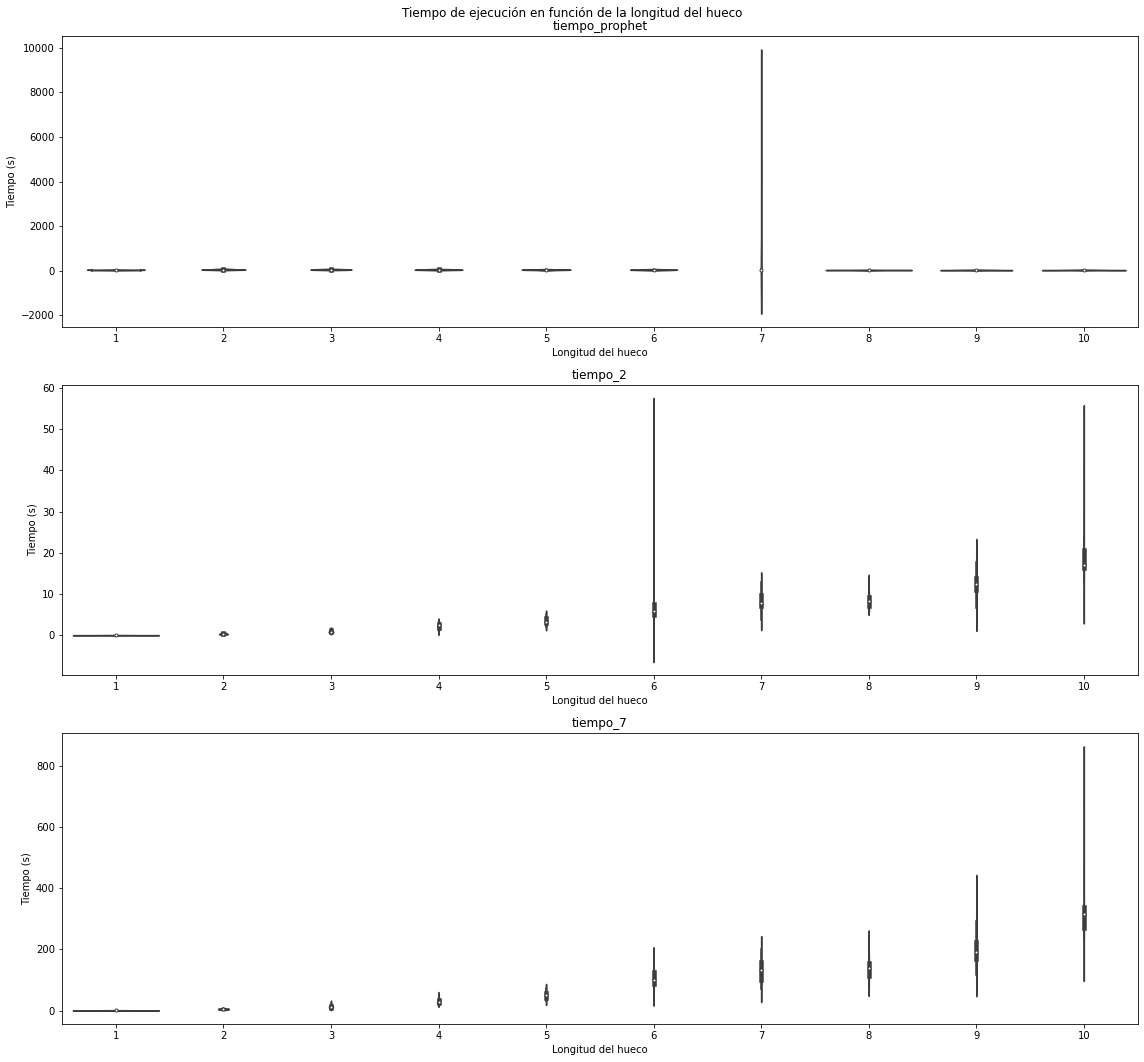

In [16]:

datos_huecos_completo.to_csv('./experimento_huecos_completo.csv', index=False)


fig, axes = plt.subplots(nrows=3,ncols=1, figsize=(16,15) )

for i in range(3):
    sns.violinplot(data=datos_huecos_completo, x='tipo' , y=datos_huecos_completo.columns[i*4+1], ax = axes[i])
    axes[i].title.set_text(datos_huecos_completo.columns[i*4+1])
    axes[i].set_xlabel('Longitud del hueco')
    axes[i].set_ylabel('Tiempo (s)')



plt.suptitle("Tiempo de ejecución en función de la longitud del hueco")
plt.tight_layout()
plt.savefig('./experimento_huecos2_variacion_tiempos.png')


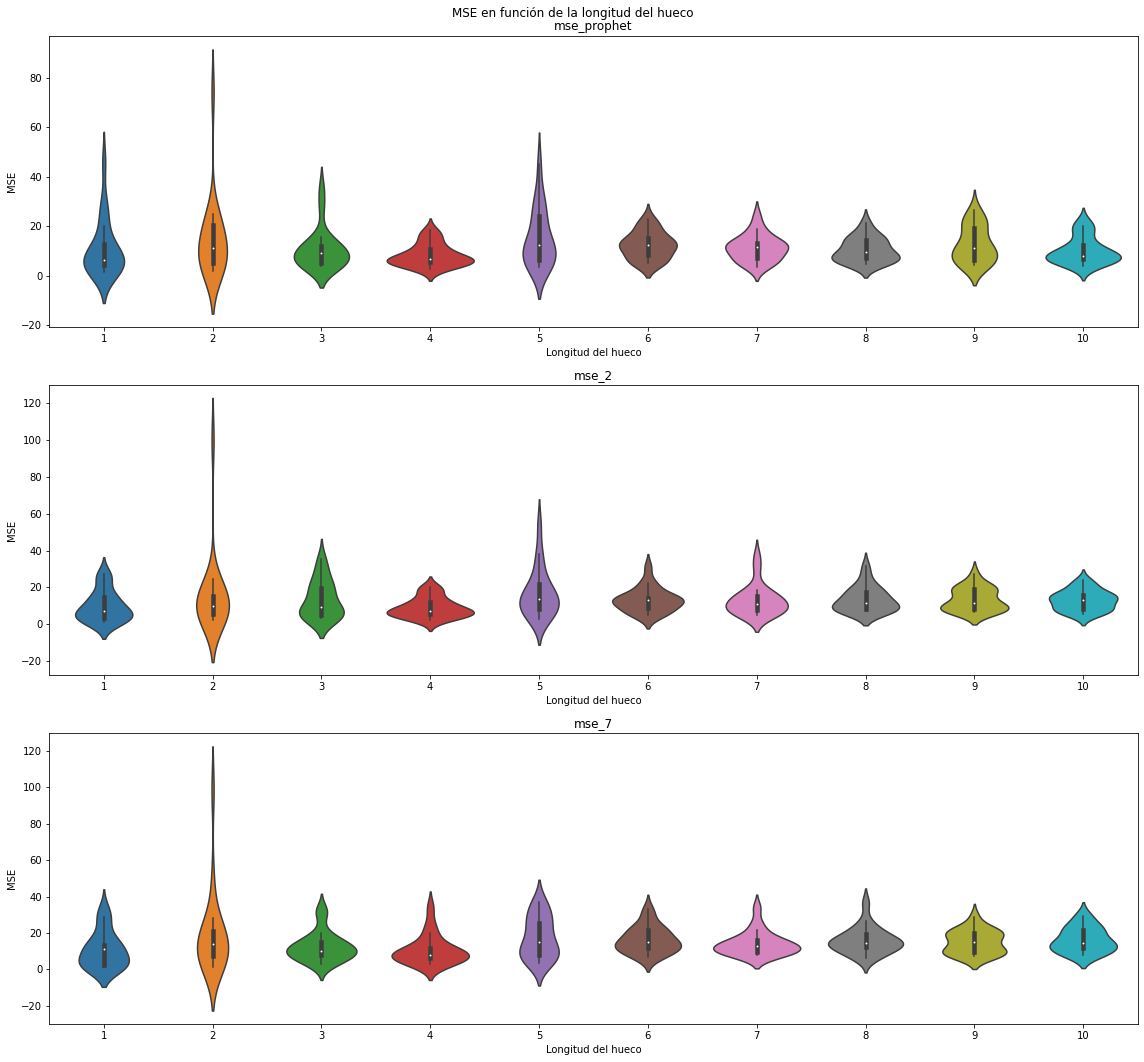

In [17]:
fig, axes = plt.subplots(nrows=3,ncols=1, figsize=(16,15) )



for i in range(3):
    sns.violinplot(data=datos_huecos_completo, x='tipo' , y=datos_huecos_completo.columns[i*4+2], ax = axes[i])
    axes[i].title.set_text(datos_huecos_completo.columns[i*4+2])
    axes[i].set_xlabel('Longitud del hueco')
    axes[i].set_ylabel('MSE')


plt.suptitle("MSE en función de la longitud del hueco")
plt.tight_layout()
plt.savefig('./experimento_hueco2_variacion_mse.png')

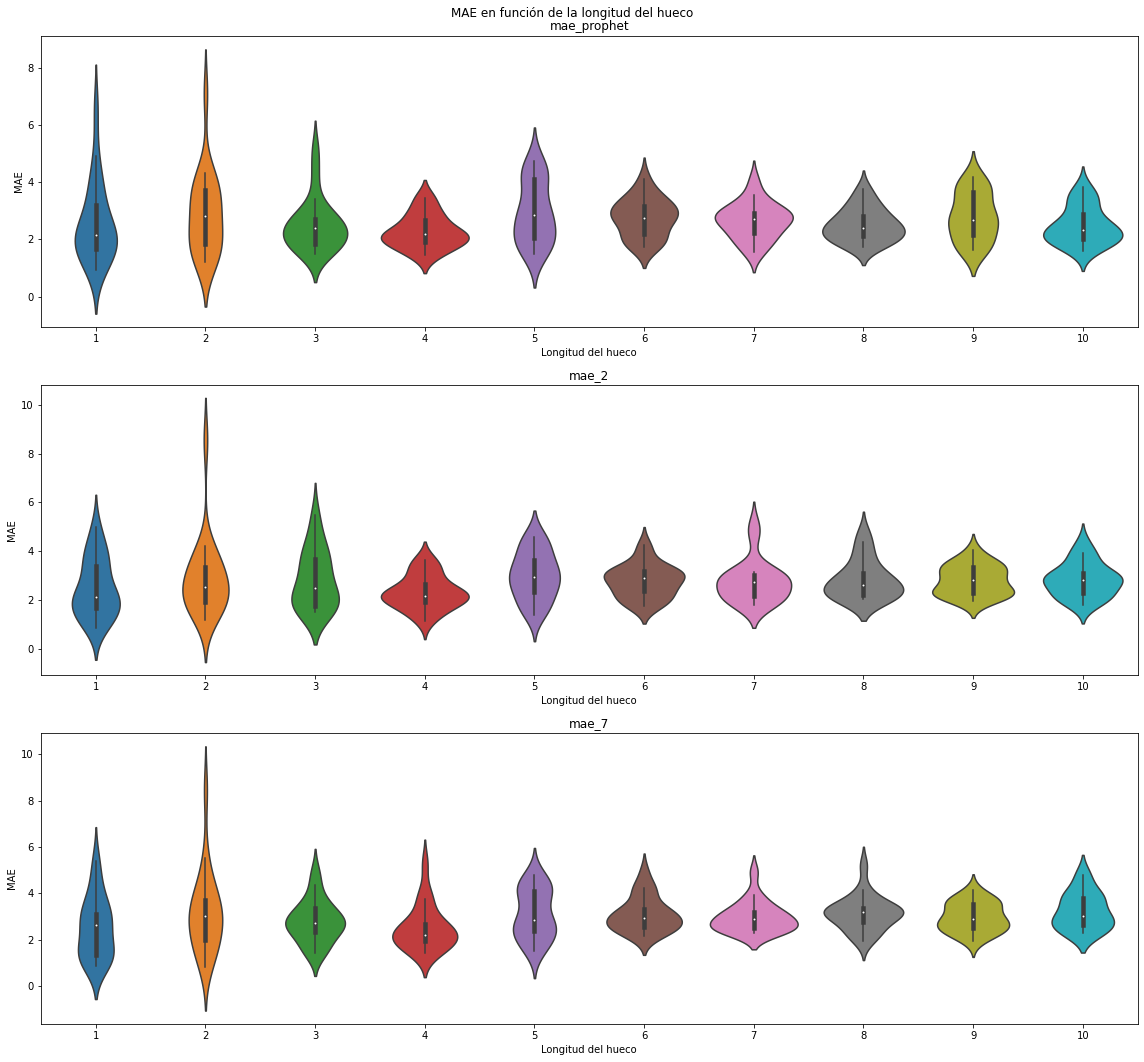

In [18]:
fig, axes = plt.subplots(nrows=3,ncols=1, figsize=(16,15) )



for i in range(3):
    sns.violinplot(data=datos_huecos_completo, x='tipo' , y=datos_huecos_completo.columns[i*4+3], ax = axes[i])
    axes[i].title.set_text(datos_huecos_completo.columns[i*4+3])
    axes[i].set_xlabel('Longitud del hueco')
    axes[i].set_ylabel('MAE')


plt.suptitle("MAE en función de la longitud del hueco")
plt.tight_layout()
plt.savefig('./experimento_hueco2_variacion_mae.png')

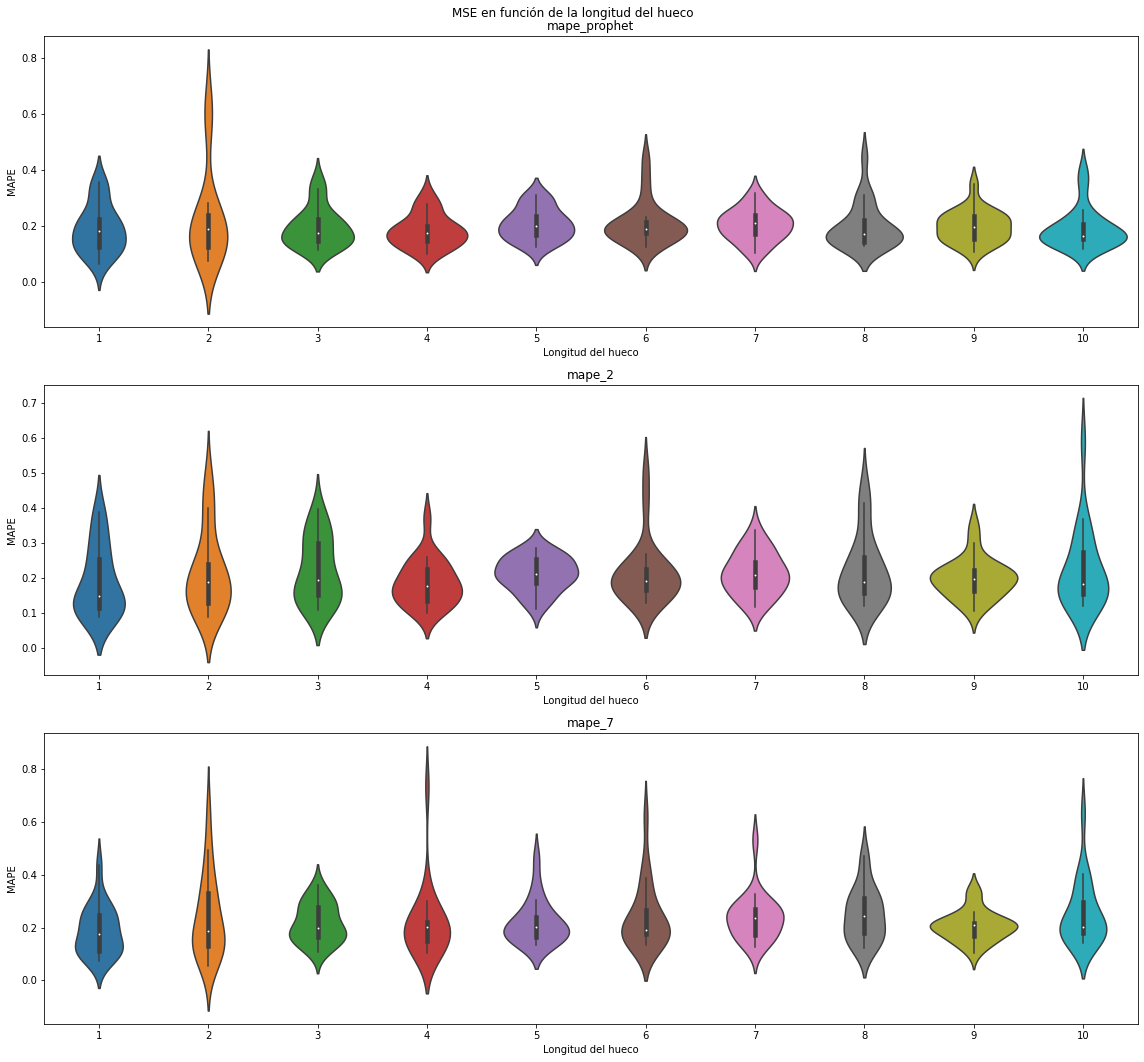

In [19]:
fig, axes = plt.subplots(nrows=3,ncols=1, figsize=(16,15) )



for i in range(3):
    sns.violinplot(data=datos_huecos_completo, x='tipo' , y=datos_huecos_completo.columns[i*4+4], ax = axes[i])
    axes[i].title.set_text(datos_huecos_completo.columns[i*4+4])
    axes[i].set_xlabel('Longitud del hueco')
    axes[i].set_ylabel('MAPE')


plt.suptitle("MSE en función de la longitud del hueco")
plt.tight_layout()
plt.savefig('./experimento_hueco2_variacion_mape.png')

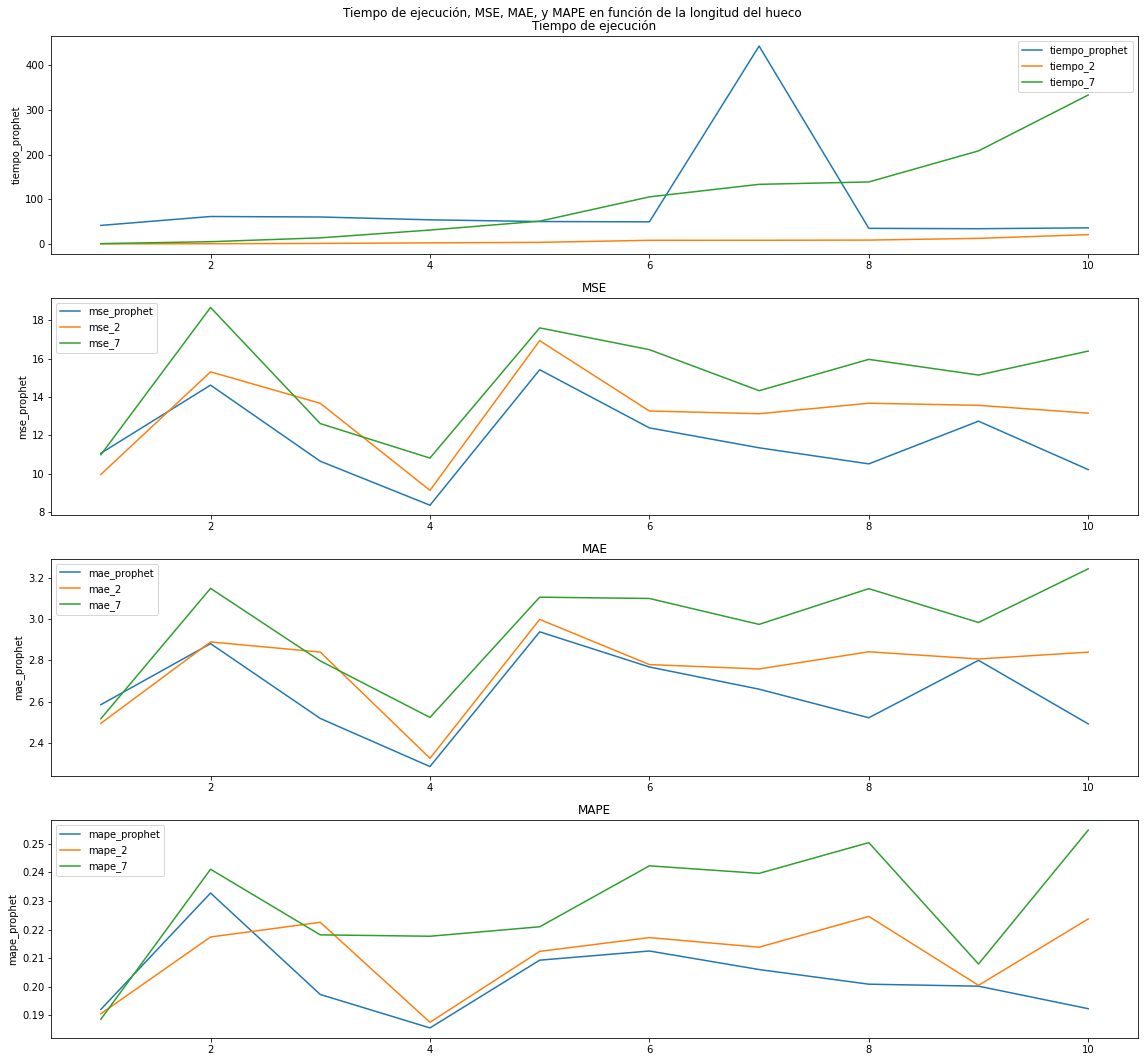

In [21]:
import seaborn as sns
x=np.arange(1,11)
fig, axes = plt.subplots(nrows=4,ncols=1, figsize=(16,15) )

for i in range(3):
    sns.lineplot(x=x, y=datos_huecos_completo.groupby('tipo').mean()[datos_huecos_completo.columns[i*4+1]], label=datos_huecos_completo.columns[i*4+1], ax = axes[0])

for i in range(3):
    sns.lineplot(x=x, y=datos_huecos_completo.groupby('tipo').mean()[datos_huecos_completo.columns[i*4+2]], label=datos_huecos_completo.columns[i*4+2], ax = axes[1])

for i in range(3):
    sns.lineplot(x=x, y=datos_huecos_completo.groupby('tipo').mean()[datos_huecos_completo.columns[i*4+3]], label=datos_huecos_completo.columns[i*4+3], ax = axes[2])

for i in range(3):
    sns.lineplot(x=x, y=datos_huecos_completo.groupby('tipo').mean()[datos_huecos_completo.columns[i*4+4]], label=datos_huecos_completo.columns[i*4+4], ax = axes[3])


axes[0].title.set_text('Tiempo de ejecución')
axes[1].title.set_text('MSE')
axes[2].title.set_text('MAE')
axes[3].title.set_text('MAPE')

plt.suptitle("Tiempo de ejecución, MSE, MAE, y MAPE en función de la longitud del hueco")
plt.tight_layout()
plt.savefig('./experimento_hueco2_detail.png')

In [22]:
b=[np.arange(1,21)]*10
b=[item for sublist in b for item in sublist]


In [24]:
datos_huecos_completo['num_ejecucion']=b

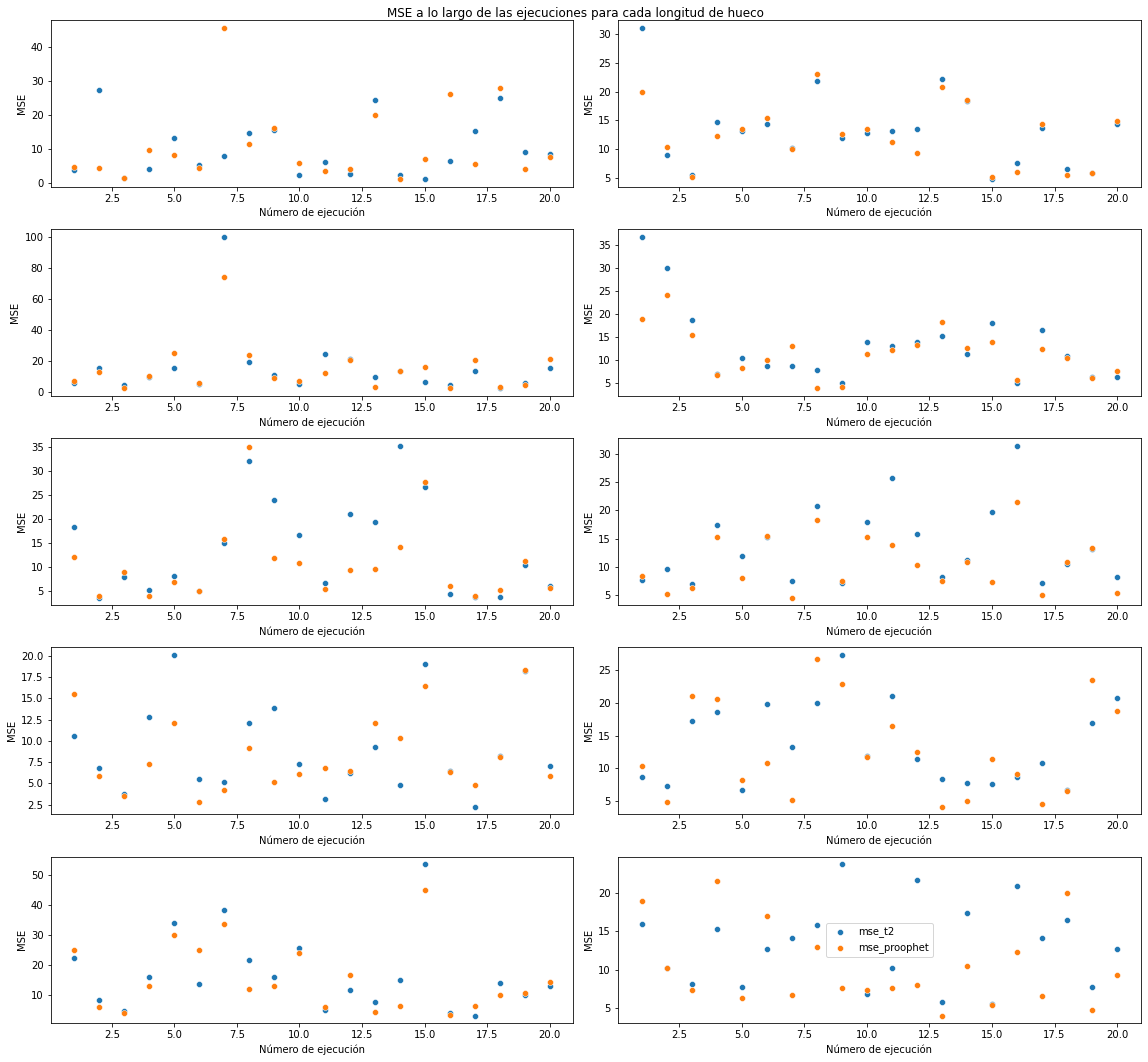

In [25]:
import seaborn as sns
x=np.arange(1,11)
fig, axes = plt.subplots(nrows=5,ncols=2, figsize=(16,15) )


for i in range(10):
    sns.scatterplot(x='num_ejecucion', y='mse_2', data=datos_huecos_completo[datos_huecos_completo['tipo']==i+1], ax = axes[i%5][int(i/5)])
    sns.scatterplot(x='num_ejecucion', y='mse_prophet', data=datos_huecos_completo[datos_huecos_completo['tipo']==i+1], ax = axes[i%5][int(i/5)])
    axes[i%5][int(i/5)].set_xlabel('Número de ejecución')
    axes[i%5][int(i/5)].set_ylabel('MSE')

plt.legend(['mse_t2', 'mse_proophet'])
plt.suptitle("MSE a lo largo de las ejecuciones para cada longitud de hueco")
plt.tight_layout()
plt.savefig('./scatter_final2.png')

Como podemos observar, el rendimiento de Prophet vs SVR con dos días de información es parecido, sin embargo, a partir de 3 huecos fusionados, empiezan a segregarse, dejando Prophet como la mejor opción. 
Por eso mismo, cuando tengamos un hueco que sea resultado de fusionar 3 huecos o más, utilizaremos Prophet.